In [7]:
import glob
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.testing.print_coercion_tables import print_new_cast_table
from scipy.stats import gmean
import scipy.stats as stats
import re
import os

from functools import reduce
from matplotlib.colors import to_rgb, to_hex
import colorsys

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [8]:
def safe_gmean(x):
    x = np.array(x)
    x = x[x > 0]  # only positive values
    return gmean(x) if len(x) > 0 else np.nan

# Helper to classify size
def size_category(size):
    if size < 8000:
        return "Small"
    elif size <= 15000:
        return "Middle"
    else:
        return "Large"
    
palette = {
    'MeDiH-MM - dyn_vs_base': 'blue',
    'MeDiH-MM - stat_vs_base': 'darkblue',
    'MeDiH-BL - dyn_vs_base': 'orange',
    'MeDiH-BL - stat_vs_base': 'darkorange',
    'MeDiH-BLC - dyn_vs_base': 'green',
    'MeDiH-BLC - stat_vs_base': 'darkgreen',
    'MeDiH-MM - internal': 'blue',  
    'MeDiH-BL - internal': 'orange',   
    'MeDiH-BLC - internal': 'green'
}

label_map = {
    "MeDiH-BL - stat_vs_base": "MeDiH-BL",
    "MeDiH-BL - dyn_vs_base": "DynMeDiH-BL",
    "MeDiH-BLC - stat_vs_base": "MeDiH-BLC",
    "MeDiH-BLC - dyn_vs_base": "DynMeDiH-BLC",
    "MeDiH-MM - stat_vs_base": "MeDiH-MM",
    "MeDiH-MM - dyn_vs_base": "DynMeDiH-MM" ,
    "MeDiH-BL - internal": "Internal MeDiH-BL",
    "MeDiH-BLC - internal": "Internal MeDiH-BLC",  
    "MeDiH-MM - internal": "Internal MeDiH-MM",
    
}
    

In [9]:

path = "./output-25-04/merged/*.txt"
pattern = r'^(BASE|A\d+).*~(\d+)_merged\.txt$'
print(path)

def read_dfs(pathR, patternR, numGroups=2):
    dfs = {}
    
    for fname in glob.glob(pathR):
        #print(fname)
        df = pd.read_csv(fname, delimiter=' ', header=0, on_bad_lines="skip")
        basename = os.path.basename(fname)
        match = re.search(patternR, basename)
        
        if match:
            algorithm = match.group(1)
            variant = match.group(numGroups)
            dfs[(algorithm, variant)] = df
        else:
            print("No match found. " + basename)
    
    return dfs


dfs=read_dfs(path, pattern)

./output-25-04/merged/*.txt


In [10]:
labels = ['A1', 'A2', 'A3', 'BASE']


# We'll store the renamed and trimmed dataframes


def merge_correct_columns(dfsOurVar, lbs):
    renamed_dfs = []
    for df, label in zip(dfsOurVar, lbs):
        # Rename selected columns
        renamed = df[['wf_name', 'inp_size', 'ms_1', 'ms_2']].copy()
        renamed = renamed.rename(columns={
            'ms_1': f'ms_1_{label}',
            'ms_2': f'ms_2_{label}',
        })    
        renamed_dfs.append(renamed)


    # Merge them all on 'wf_name'
   
    merged_df = reduce(lambda left, right: pd.merge(left, right, on=['wf_name', 'inp_size']), renamed_dfs)


    merged_df['size'] = merged_df['wf_name'].str.extract(r'_(\d+)\.')[0].fillna("100")
    merged_df['size'] = merged_df['size'].astype(int)


    for col in merged_df.columns:
        if col.startswith("ms_"):
            merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")
    
    return merged_df





In [88]:
# List your algorithms (excluding BASE)
algos = ['A1', 'A2', 'A3']

def buld_plot_df(merged_df):
    # For storing all ratios in long format
    ratios = []

    for algo in algos:
        df = merged_df.copy()
        df['size'] = df['size']  # group key

        # Compute the 3 relations
        df['internal'] = df[f'ms_1_{algo}'] / df[f'ms_2_{algo}']
        df['dyn_vs_base'] =  df['ms_2_BASE'] /df[f'ms_1_{algo}']
        df['stat_vs_base'] =  df['ms_2_BASE'] / df[f'ms_2_{algo}']
        #df['stat_vs_base'] = np.where((df['stat_vs_base'] > 1) & (df['size'] == 100), 1, df['stat_vs_base'])
        #df['dyn_vs_base'] = np.where((df['dyn_vs_base'] > 1) & (df['size'] == 100), 1, df['dyn_vs_base'])
        #df['internal'] = np.where((df['internal'] > 1) & (df['size'] == 100), 1, df['internal'])

        #print("df in build, before merge ", df)

        # Reshape to long format for seaborn
        melted = df[['size', 'wf_name', 'internal','inp_size', 'dyn_vs_base', 'stat_vs_base']].melt(#
            id_vars=['size', 'wf_name','inp_size'],
            var_name='relation',
            value_name='ratio'
        )
        melted['algorithm'] = algo

        ratios.append(melted)

    # Concatenate all into one DataFrame
    pl_df = pd.concat(ratios, ignore_index=True)

    algo_aliases = {
        'A1': 'MeDiH-BL',
        'A2': 'MeDiH-BLC',
        'A3': 'MeDiH-MM'
    }

    pl_df['algorithm'] = pl_df['algorithm'].replace(algo_aliases)
    return pl_df

#plot_df = buld_plot_df(merged_df_var1)
#print(plot_df.head())


In [45]:
path = "./param-study-penalty/merged/*.txt"
print(path)

patterndevs = r'^(BASE|A\d+)-(ndev|dev)~(pen\d\d\d)'

dfs=read_dfs(path,patterndevs, 3)
#print(dfs)

./param-study-penalty/merged/*.txt


In [11]:

dfsVar1 = [dfs[('A1','pen111')], dfs[('A1','pen101')], dfs[('A1','pen201')], dfs[('A1','pen301')],
           dfs[('A1','pen401')], dfs[('A1','pen501')]]

dfsBase = [dfs[('BASE','pen111')], dfs[('BASE','pen101')], dfs[('BASE','pen201')], dfs[('BASE','pen301')],
           dfs[('BASE','pen401')], dfs[('BASE','pen501')]]

def pltParams():
    plt.figure(figsize=(24, 12))
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.xlabel('size', fontsize=18)
    plt.ylabel('ratio', fontsize=18)
    plt.legend(fontsize=18)  
    
def removeUnnecessaryColumns(dfsVar, dfsBs):
    dv1=[]
    for df in dfsVar:
        df= df.drop('dur_alg1', axis=1)
        df= df.drop('ms_perc', axis=1)
        df= df.drop('dur_alg2', axis=1)
        dv1.append(df)

    db=[]
    for df in dfsBs:
        df= df.drop('dur_alg1', axis=1)
        df= df.drop('ms_perc', axis=1)
        df= df.drop('dur_alg2', axis=1)
        db.append(df) 
    
    return dv1


def processParameterStudy(dfsVar,dfsBs, algname, title, labels_plot, measure="penalties", relation="stat_vs_base"): 
      
    dv1= removeUnnecessaryColumns(dfsVar, dfsBs)

    #print(db)
    drel=[]
    labels = [algname, 'BASE']
    for i, val in enumerate(dv1):
        print("############", i,"#################################")
        df = val.dropna().copy()
        df.loc[:, 'ms_1'] = df['ms_1'].astype(float)
        df = merge_correct_columns([df, dfsBs[i]], labels)
      
        df['dyn_vs_base'] =  df['ms_2_BASE'] / df[f'ms_1_{algname}'] 
        df['stat_vs_base'] =  df['ms_2_BASE'] / df[f'ms_2_{algname}']       
        df.to_csv(f'drelParamStudy{algname}-{measure}-{i}.csv')
        drel.append(df)
        
        
    addition= "its static variant" if relation=="internal" else "the baseline"
    avg_data = []
    
    for df, label in zip(drel, labels_plot): 
        avg_dyn_vs_base = safe_gmean(df["dyn_vs_base"])
        avg_stat_vs_base = safe_gmean(df["stat_vs_base"])    
        avg_data.append({"label": label, "relation": "dyn_vs_base", "avg": avg_dyn_vs_base})
        avg_data.append({"label": label, "relation": "stat_vs_base", "avg": avg_stat_vs_base})

        
    # Create a summary dataframe
    avg_df = pd.DataFrame(avg_data)
    print(avg_df)
    print(f"avg_{relation}")

    # Plot   
    plt.figure(figsize=(24, 12))
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)   
    plt.legend(fontsize=18)  
    #ax = sns.barplot(data=avg_df, x="label", y=f"avg_{relation}", color="skyblue")
    ax = sns.barplot(data=avg_df, x="label", y="avg", hue="relation", palette="Blues")
    ax.set_yscale("log") 
    plt.ylabel("Makespan improvement \nin comparison to baseline, log")
    ax.set_xlabel(f"{measure}", fontsize=18)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Relative makespan improvement (how much faster is {addition} {algname} \ncompared to the baseline, for different {measure})")
    plt.tight_layout()
   
    plt.show()
   
    # Get Seaborn default  palette (3 colors)
    default_colors = sns.color_palette(n_colors=3)
    size_categories = ["Small", "Middle", "Large"]
    base_colors = dict(zip(size_categories, default_colors))

    # Function to darken color
    def darken(color, factor=0.6):
        h, l, s = colorsys.rgb_to_hls(*to_rgb(color))
        l = max(0, min(1, l * factor))
        return to_hex(colorsys.hls_to_rgb(h, l, s))

    # Build palette
    palette = {}
    for size_cat in size_categories:
        light_color = base_colors[size_cat]
        palette[f"dyn_vs_base-{size_cat}"] = to_hex(light_color)
        palette[f"stat_vs_base-{size_cat}"] = darken(light_color)

    # Build data
    relations = ["dyn_vs_base", "stat_vs_base"]
    avg_data = []

    for relation in relations:
        for df, label in zip(drel, labels_plot):
            df = df.copy()
            df["size_category"] = df["size"].apply(size_category)
            grouped = df.groupby("size_category")[relation].agg(safe_gmean).reset_index()

            for _, row in grouped.iterrows():
                avg_data.append({
                    "label": label,
                    "size_category": row["size_category"],
                    "relation_type": relation,
                    "avg_relation": row[relation]
                })

    avg_df = pd.DataFrame(avg_data)
    avg_df["hue_label"] = avg_df["relation_type"] + "-" + avg_df["size_category"]

    # Plot
    plt.figure(figsize=(24, 12))
    ax = sns.barplot(data=avg_df, x="label", y="avg_relation", hue="hue_label", palette=palette)

    if "internal" not in relations:
        ax.set_yscale("log")

    plt.ylabel("Average makespan improvement \nin comparison to baseline", fontsize=18)
    plt.xlabel(f"{measure}", fontsize=18)
    plt.title(f"Relative makespan improvement (how much faster is {addition} {algname} \ncompared to the baseline, for different {measure})", fontsize=20)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(title="Relation-Size Category", fontsize=14, title_fontsize=16)
    plt.tight_layout()
    plt.savefig(f"paramstudy_{measure}_both_in_one_defaultcolor.png", dpi=300, bbox_inches='tight')
    plt.show()
  
custom_labels = ["1", "10", "100", "1000", f"$10^4$",f"$10^5$"]
processParameterStudy(dfsVar1, dfsBase, "MeDiH-BL", "Title", custom_labels, "penalties", "dyn_vs_base")
processParameterStudy(dfsVar1, dfsBase, "MeDiH-BL", "Title", custom_labels, "penalties")

KeyError: ('A1', 'pen111')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
############ 4 #################################
############ 5 #################################
       label      relation           avg
0     no pen   dyn_vs_base      1.761882
1     no pen  stat_vs_base      2.007014
2     10xpen   dyn_vs_base     23.037235
3     10xpen  stat_vs_base     26.322439
4    100xpen   dyn_vs_base    111.171909
5    100xpen  stat_vs_base    126.535806
6   1000xpen   dyn_vs_base    570.117196
7   1000xpen  stat_vs_base    649.527744
8    10^4pen   dyn_vs_base   2842.811859
9    10^4pen  stat_vs_base   3239.345787
10   10^5pen   dyn_vs_base  14567.708229
11   10^5pen  stat_vs_base  16561.887076
avg_stat_vs_base


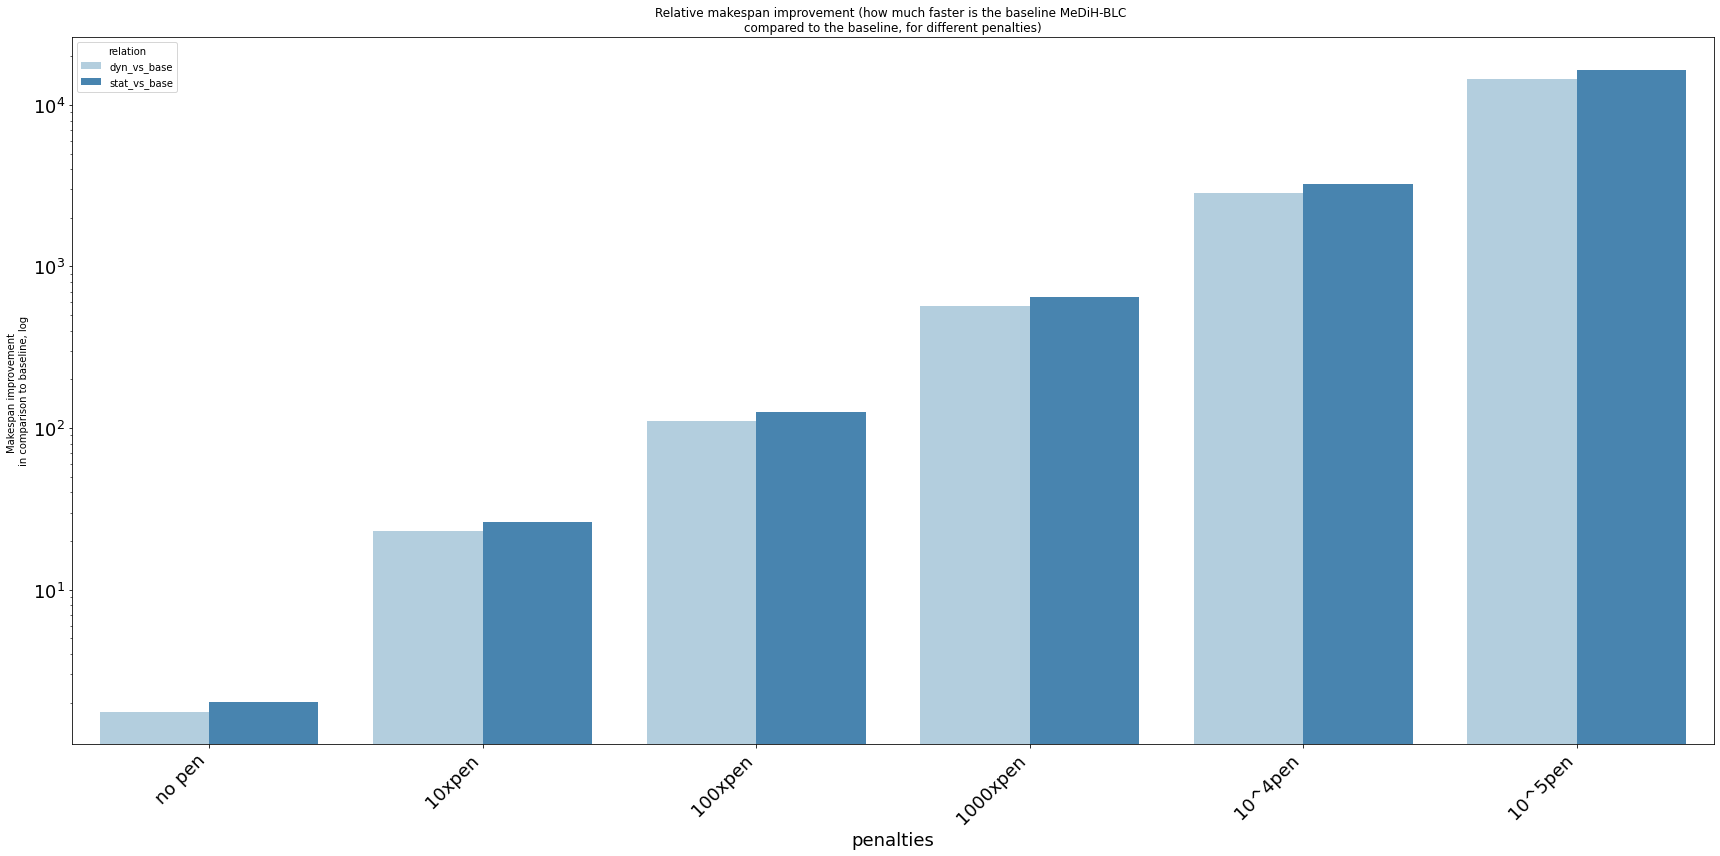

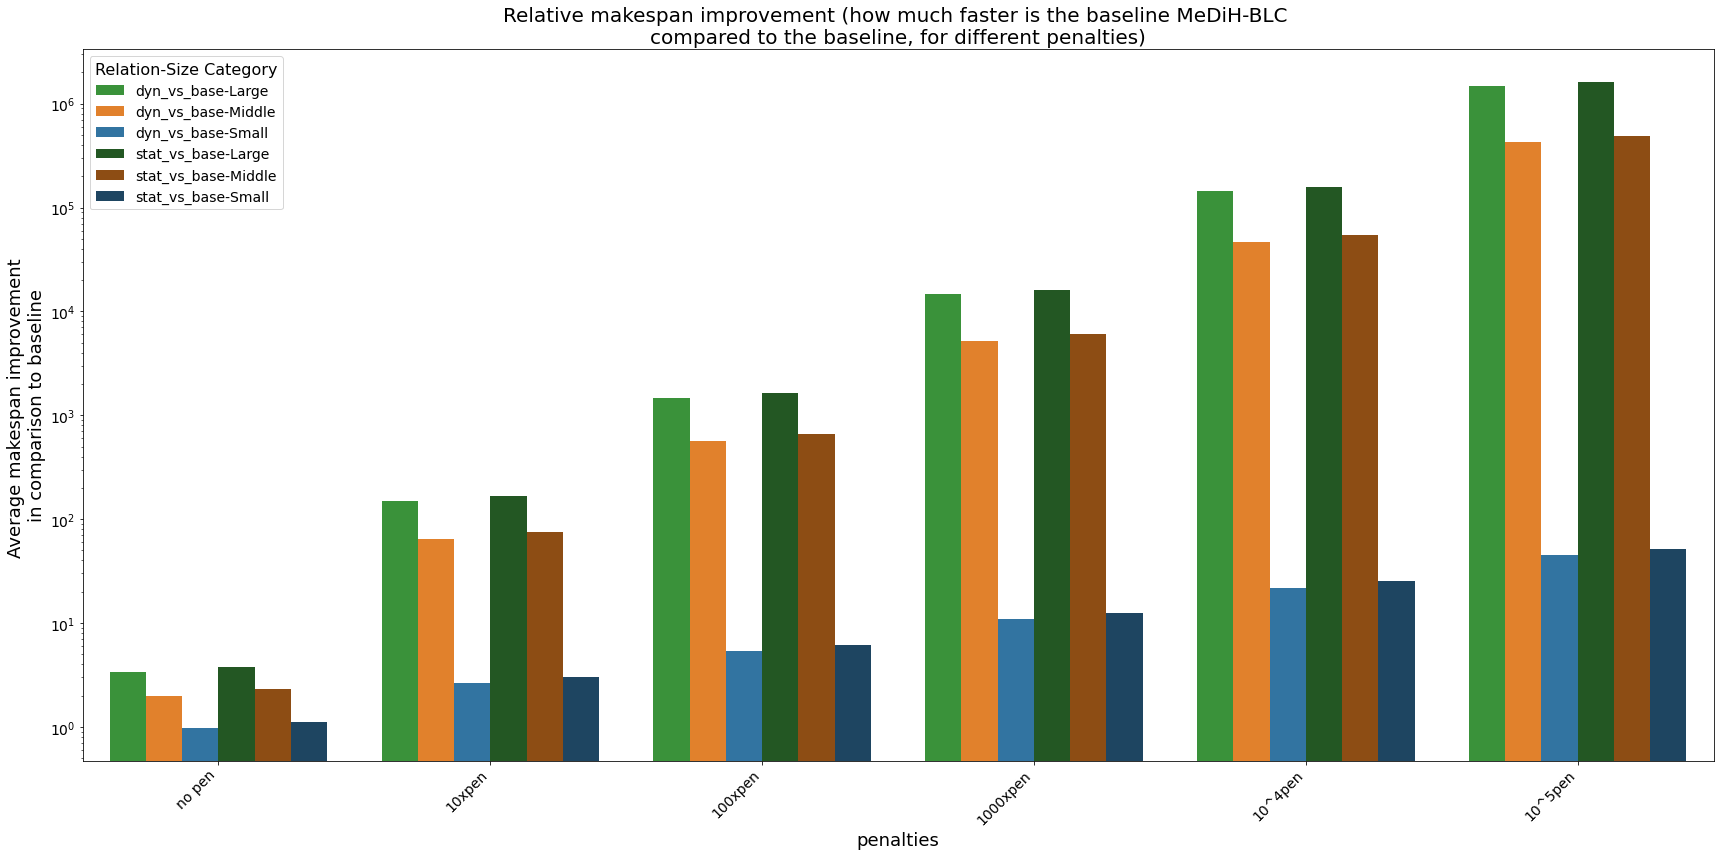

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
############ 4 #################################
############ 5 #################################
       label      relation           avg
0     no pen   dyn_vs_base      1.761882
1     no pen  stat_vs_base      2.007014
2     10xpen   dyn_vs_base     23.037235
3     10xpen  stat_vs_base     26.322439
4    100xpen   dyn_vs_base    111.171909
5    100xpen  stat_vs_base    126.535806
6   1000xpen   dyn_vs_base    570.117196
7   1000xpen  stat_vs_base    649.527744
8    10^4pen   dyn_vs_base   2842.811859
9    10^4pen  stat_vs_base   3239.345787
10   10^5pen   dyn_vs_base  14567.708229
11   10^5pen  stat_vs_base  16561.887076
avg_stat_vs_base


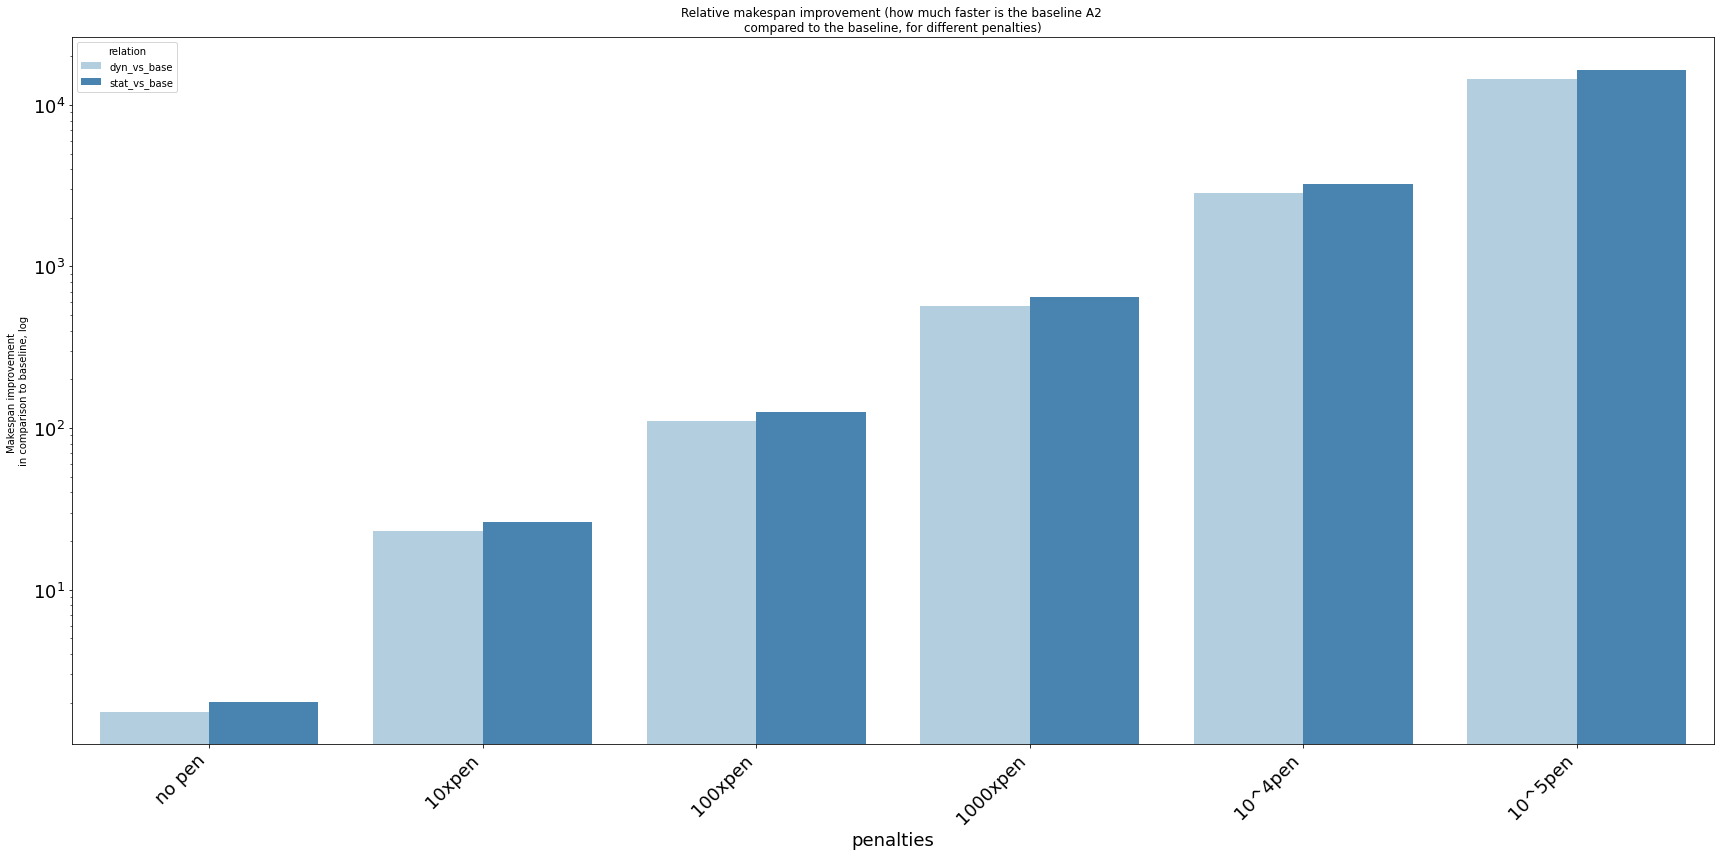

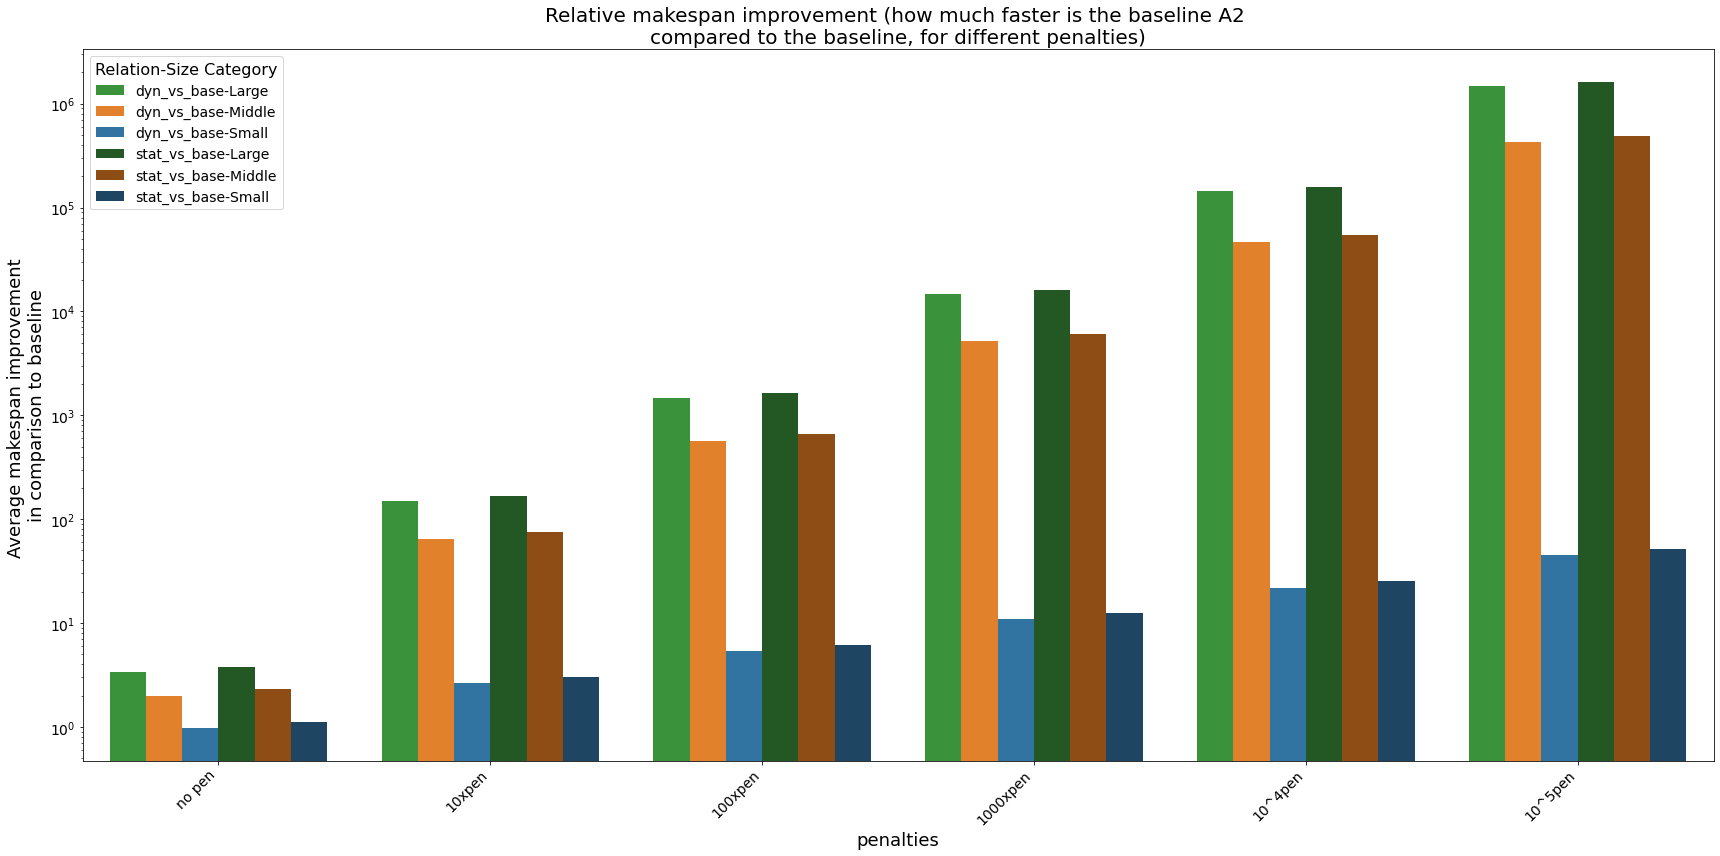

In [50]:
dfsVar2 = [dfs[('A2','pen111')], dfs[('A2','pen101')], dfs[('A2','pen201')], dfs[('A2','pen301')],
           dfs[('A2','pen401')], dfs[('A2','pen501')]]
custom_labels = ["no pen", "10xpen", "100xpen", "1000xpen", "10^4pen","10^5pen"]
processParameterStudy(dfsVar2, dfsBase, "MeDiH-BLC", "Title",custom_labels)
processParameterStudy(dfsVar2, dfsBase, "A2", "Title",custom_labels)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
############ 4 #################################
############ 5 #################################
       label      relation           avg
0     no pen   dyn_vs_base      1.762499
1     no pen  stat_vs_base      1.314167
2     10xpen   dyn_vs_base     23.004503
3     10xpen  stat_vs_base     17.216484
4    100xpen   dyn_vs_base    115.087962
5    100xpen  stat_vs_base     86.130437
6   1000xpen   dyn_vs_base    577.289677
7   1000xpen  stat_vs_base    431.788127
8    10^4pen   dyn_vs_base   2840.445802
9    10^4pen  stat_vs_base   2118.350011
10   10^5pen   dyn_vs_base  14929.011485
11   10^5pen  stat_vs_base  11171.195707
avg_stat_vs_base


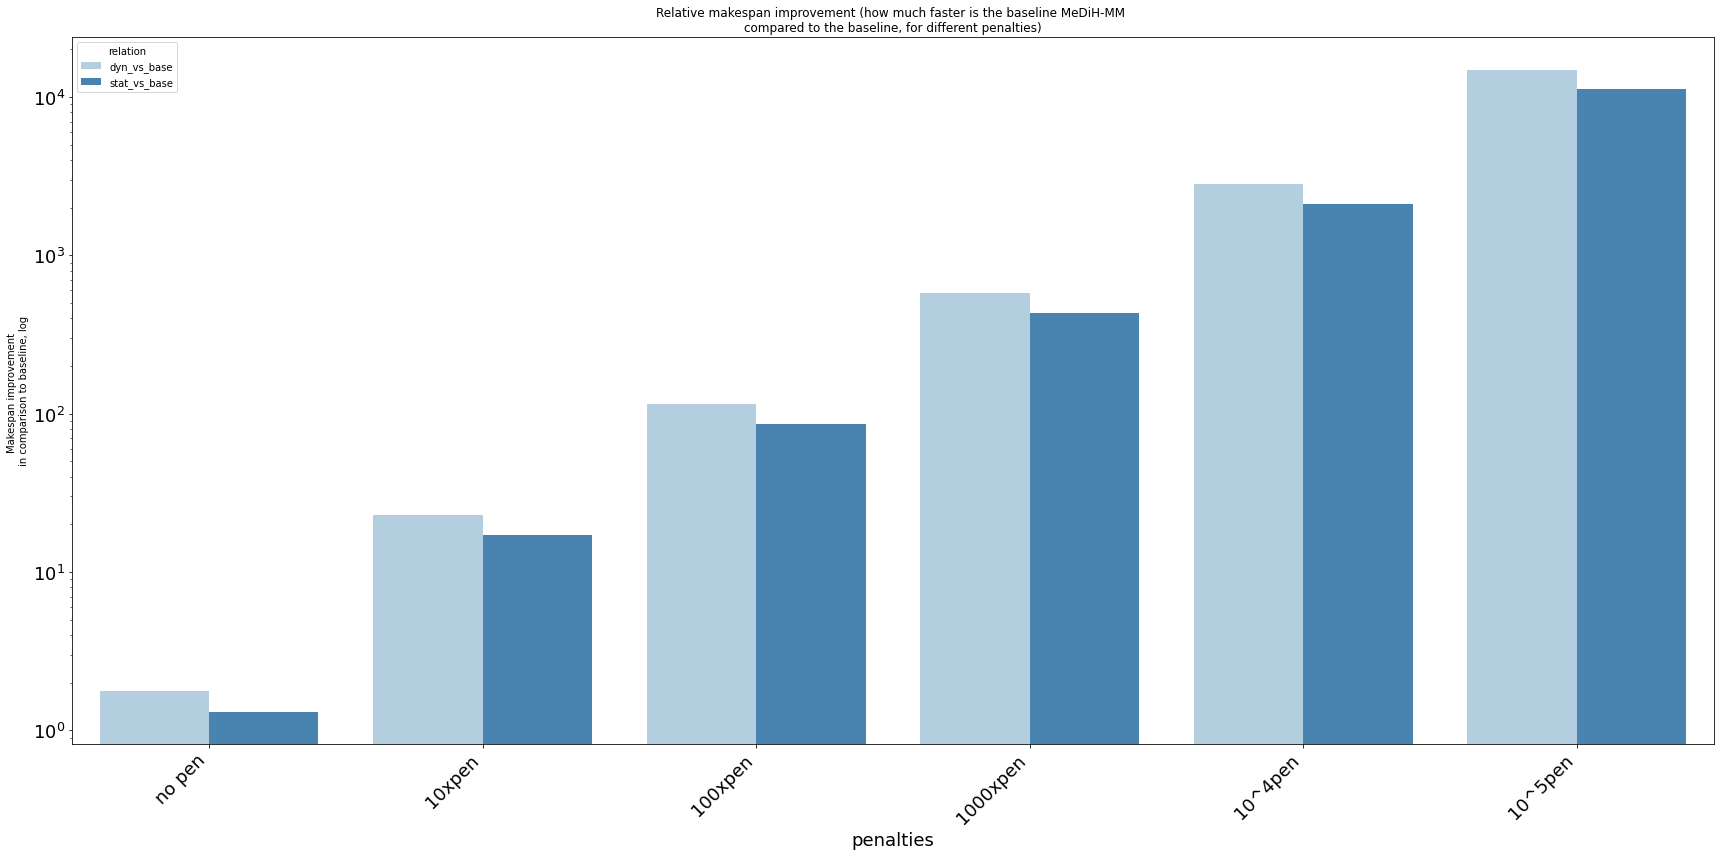

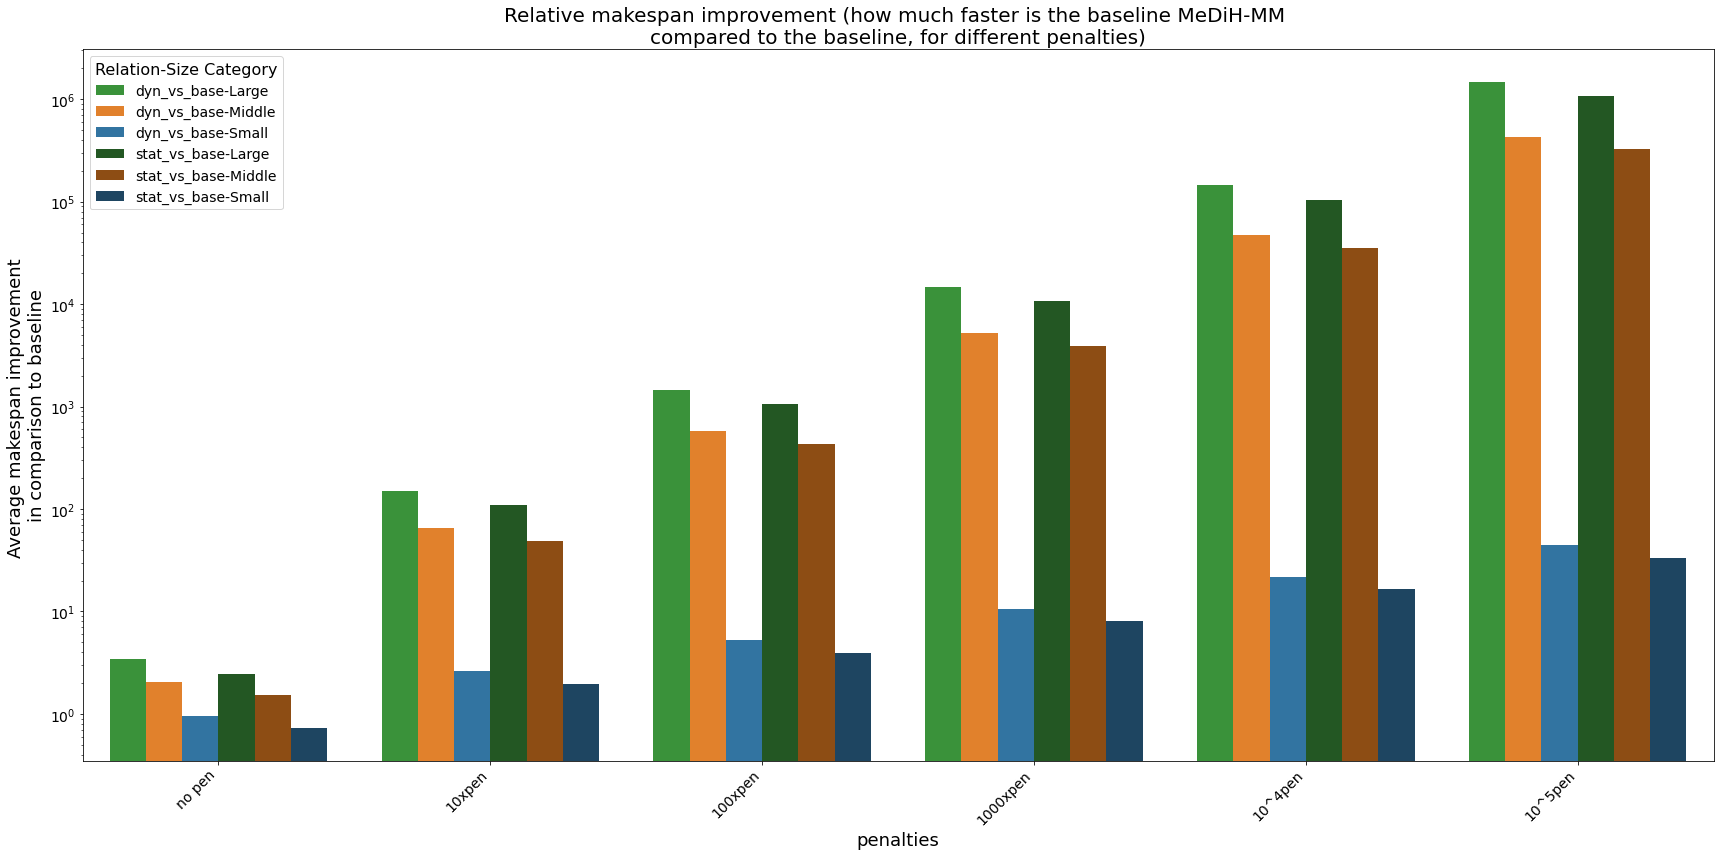

In [51]:
dfsVar3 = [dfs[('A3','pen111')], dfs[('A3','pen101')], dfs[('A3','pen201')], dfs[('A3','pen301')],
           dfs[('A3','pen401')], dfs[('A3','pen501')]]
custom_labels = ["no pen", "10xpen", "100xpen", "1000xpen", "10^4pen","10^5pen"]
processParameterStudy(dfsVar3, dfsBase, "MeDiH-MM", "Title",custom_labels)

In [52]:
path = "./param-study-rw/merged/*.txt"
print(path)

patterndevs = r'^(BASE|A\d+)-(rw\d\d\d)'

dfsrw=read_dfs(path,patterndevs, 2)
#print(dfsrw)

./param-study-rw/merged/*.txt


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
############ 4 #################################
         label      relation            avg
0    10xfaster   dyn_vs_base  110033.394539
1    10xfaster  stat_vs_base  110875.603473
2    no change   dyn_vs_base   43675.154272
3    no change  stat_vs_base   45802.191247
4    10xslower   dyn_vs_base    7773.256445
5    10xslower  stat_vs_base    8565.707095
6   100xslower   dyn_vs_base    1039.975479
7   100xslower  stat_vs_base    1218.783559
8  1000xslower   dyn_vs_base     141.261705
9  1000xslower  stat_vs_base     170.905152
avg_internal


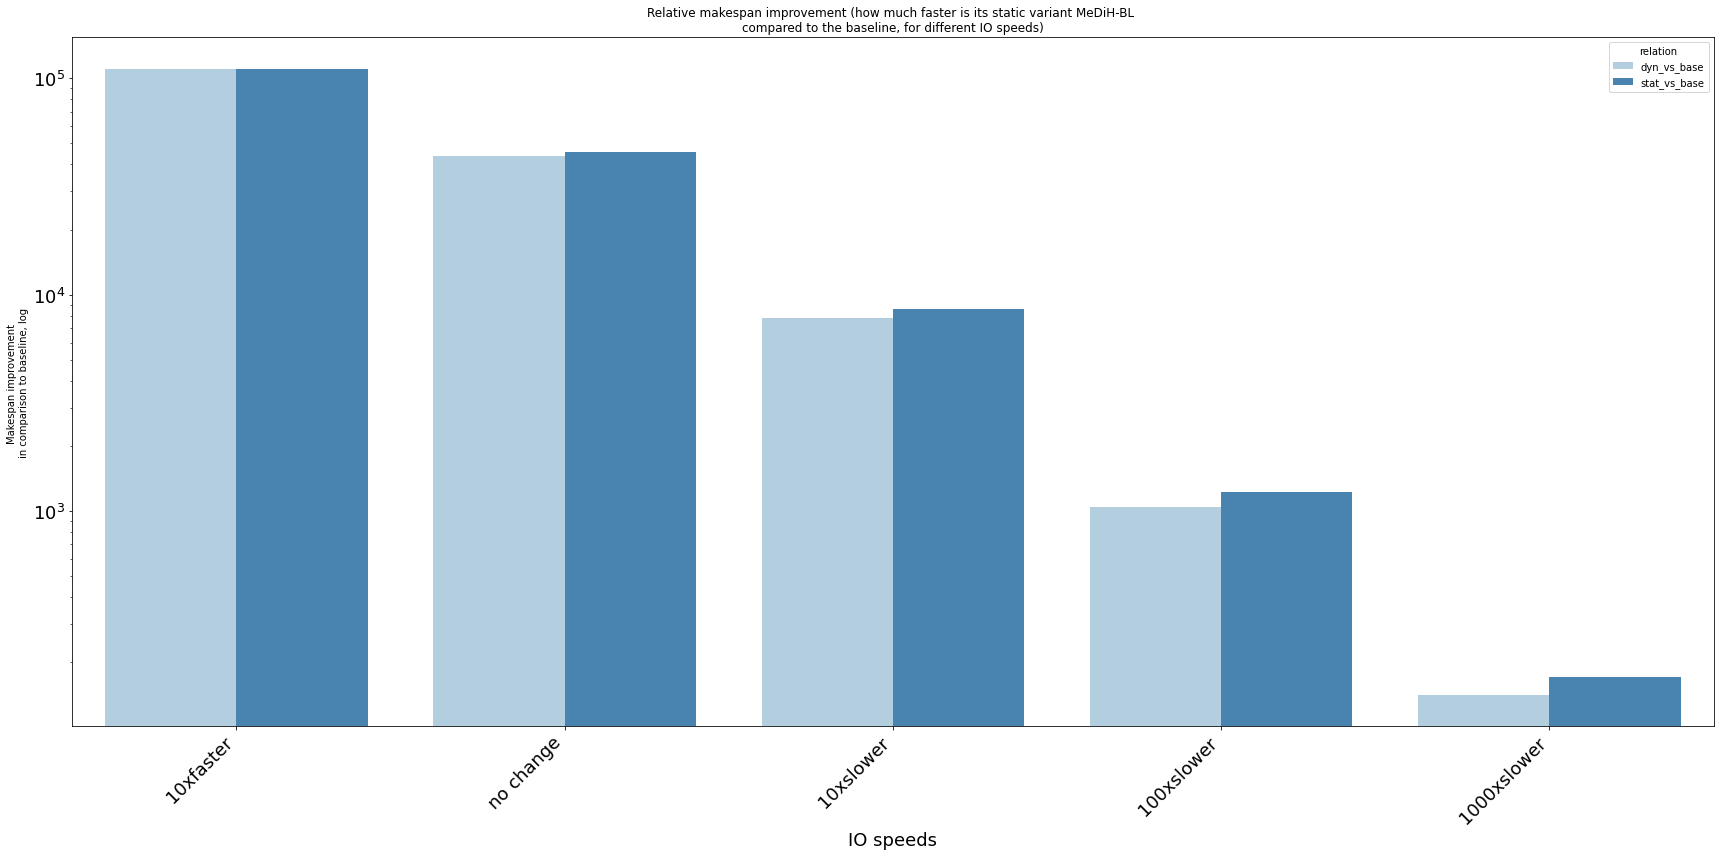

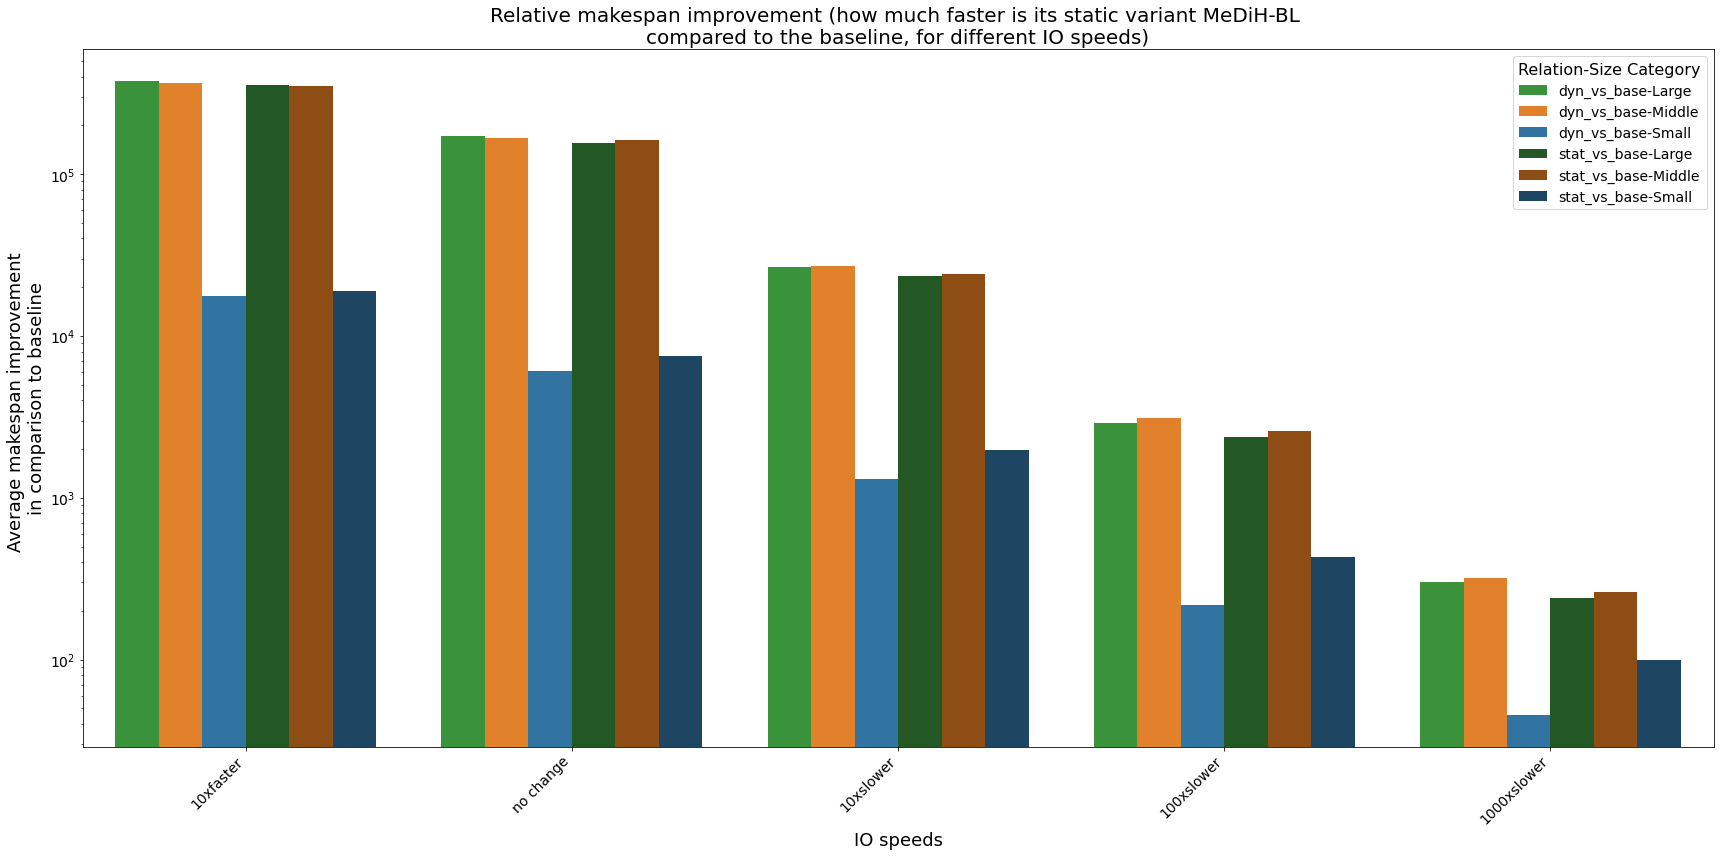

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
############ 4 #################################
         label      relation            avg
0    10xfaster   dyn_vs_base  110033.394539
1    10xfaster  stat_vs_base  110875.603473
2    no change   dyn_vs_base   43675.154272
3    no change  stat_vs_base   45802.191247
4    10xslower   dyn_vs_base    7773.256445
5    10xslower  stat_vs_base    8565.707095
6   100xslower   dyn_vs_base    1039.975479
7   100xslower  stat_vs_base    1218.783559
8  1000xslower   dyn_vs_base     141.261705
9  1000xslower  stat_vs_base     170.905152
avg_stat_vs_base


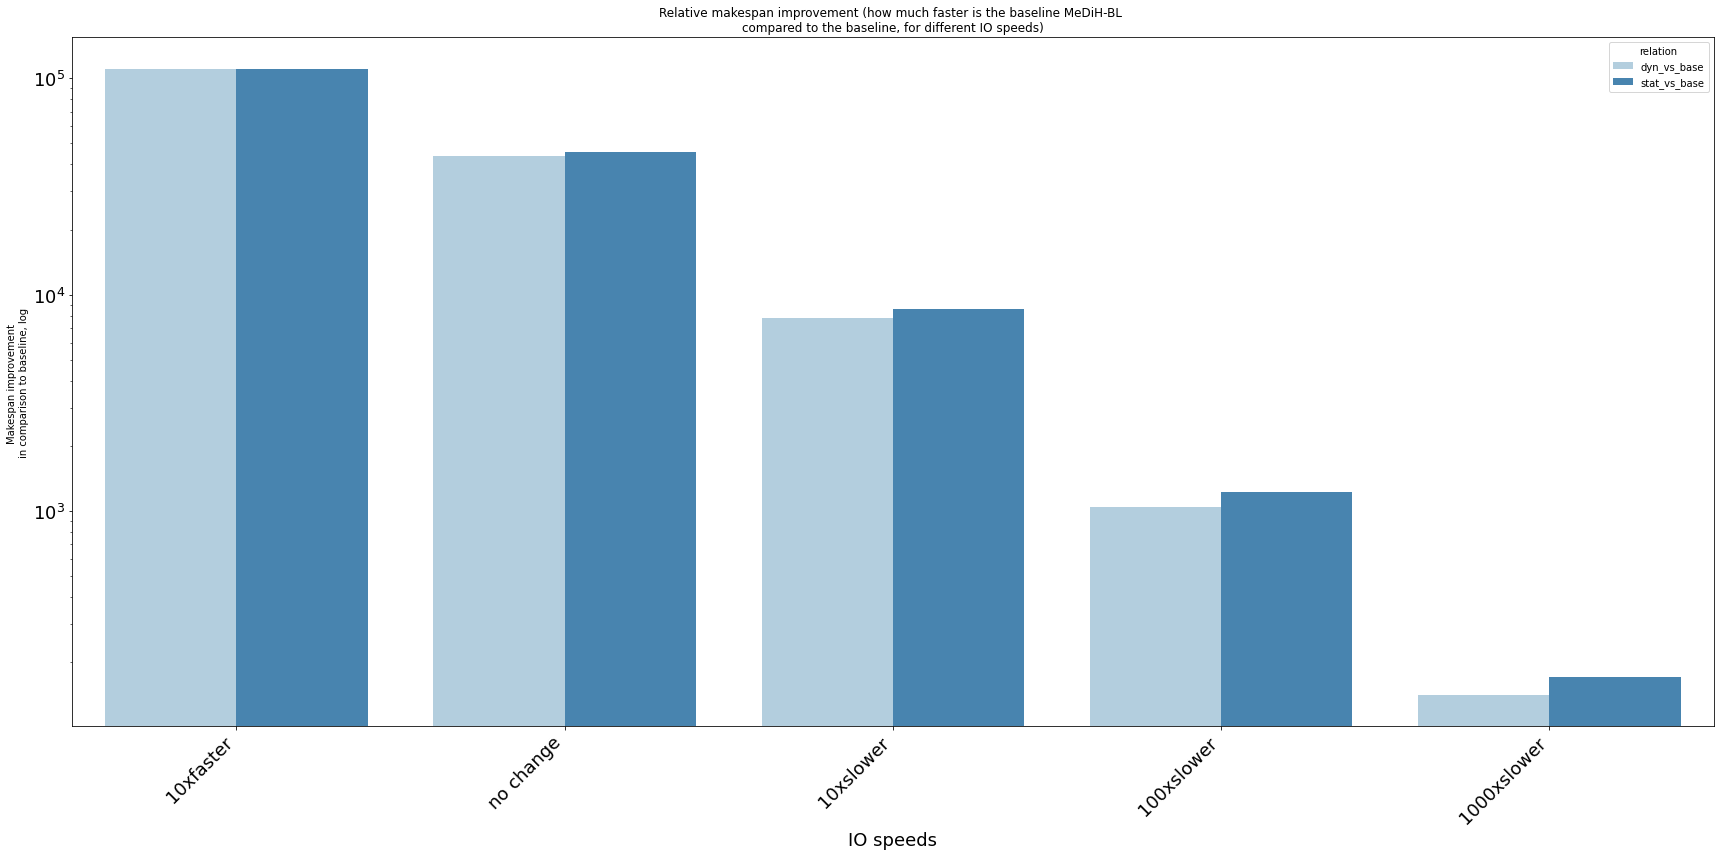

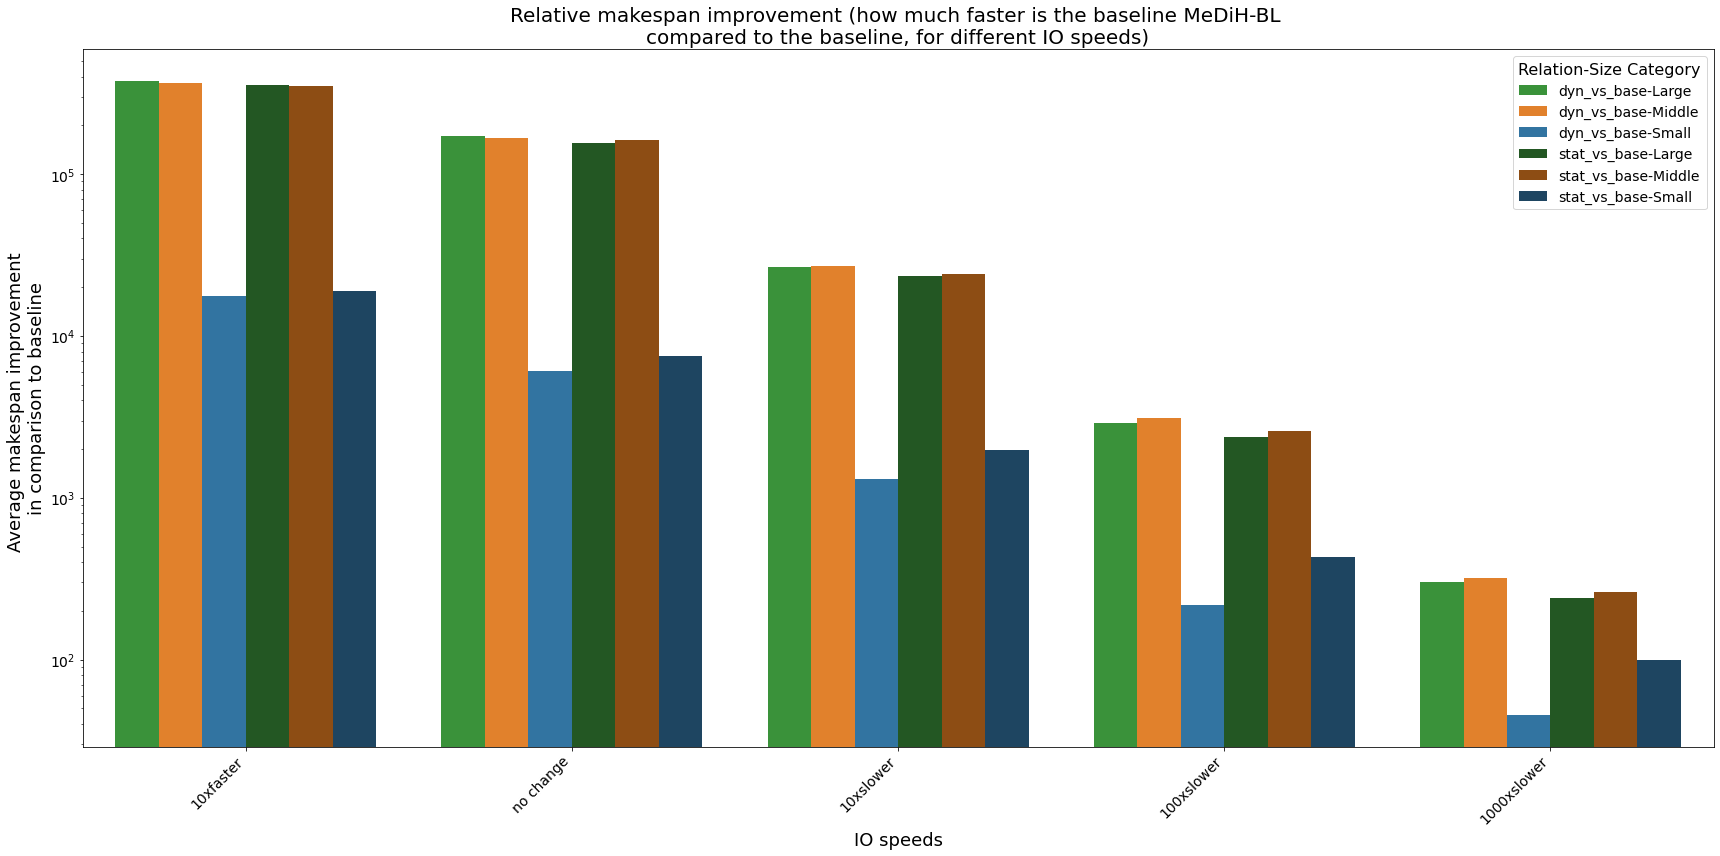

In [53]:
dfsVar1 = [dfsrw[('A1','rw100')], dfsrw[('A1','rw010')], dfsrw[('A1','rw001')], dfsrw[('A1','rw101')],
           dfsrw[('A1','rw201')]]

dfsBase = [dfsrw[('BASE','rw100')], dfsrw[('BASE','rw010')], dfsrw[('BASE','rw001')], dfsrw[('BASE','rw101')],
           dfsrw[('BASE','rw201')]]

custom_labels = ["10xfaster", "no change", "10xslower", "100xslower", "1000xslower"]
processParameterStudy(dfsVar1, dfsBase, "MeDiH-BL", "Title", custom_labels, "IO speeds", "internal")
processParameterStudy(dfsVar1, dfsBase, "MeDiH-BL", "Title", custom_labels, "IO speeds")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
############ 4 #################################
         label      relation            avg
0    10xfaster   dyn_vs_base  109557.967849
1    10xfaster  stat_vs_base   51473.586800
2    no change   dyn_vs_base   43406.791580
3    no change  stat_vs_base   38905.813063
4    10xslower   dyn_vs_base    7726.791523
5    10xslower  stat_vs_base   18018.891122
6   100xslower   dyn_vs_base    1064.334212
7   100xslower  stat_vs_base    6141.030330
8  1000xslower   dyn_vs_base     141.931146
9  1000xslower  stat_vs_base    1697.810525
avg_internal


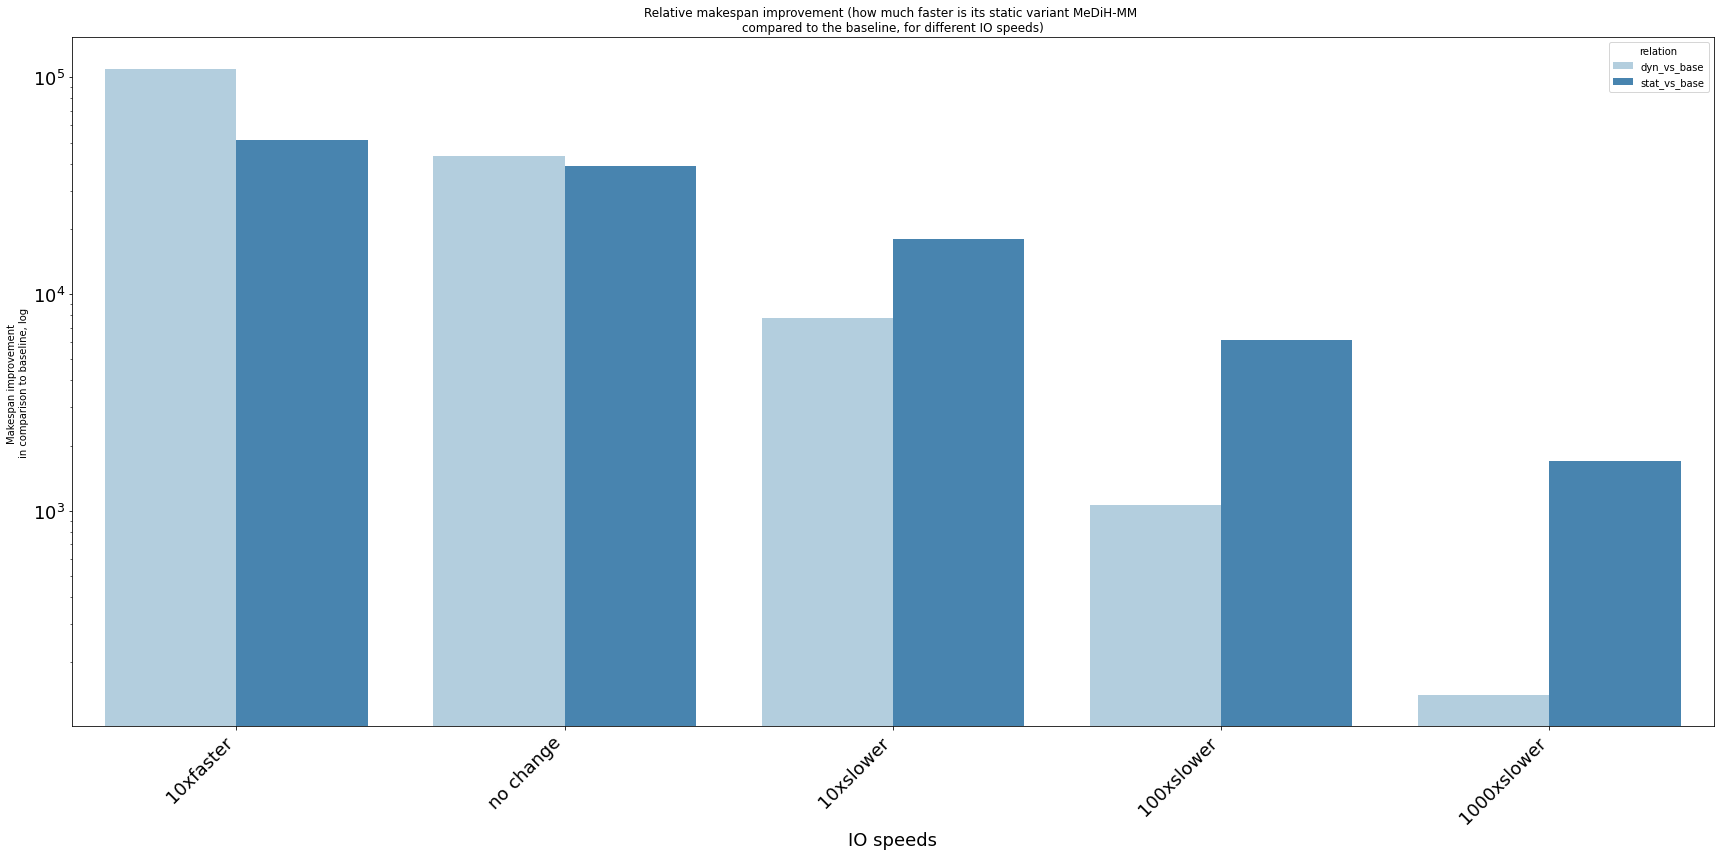

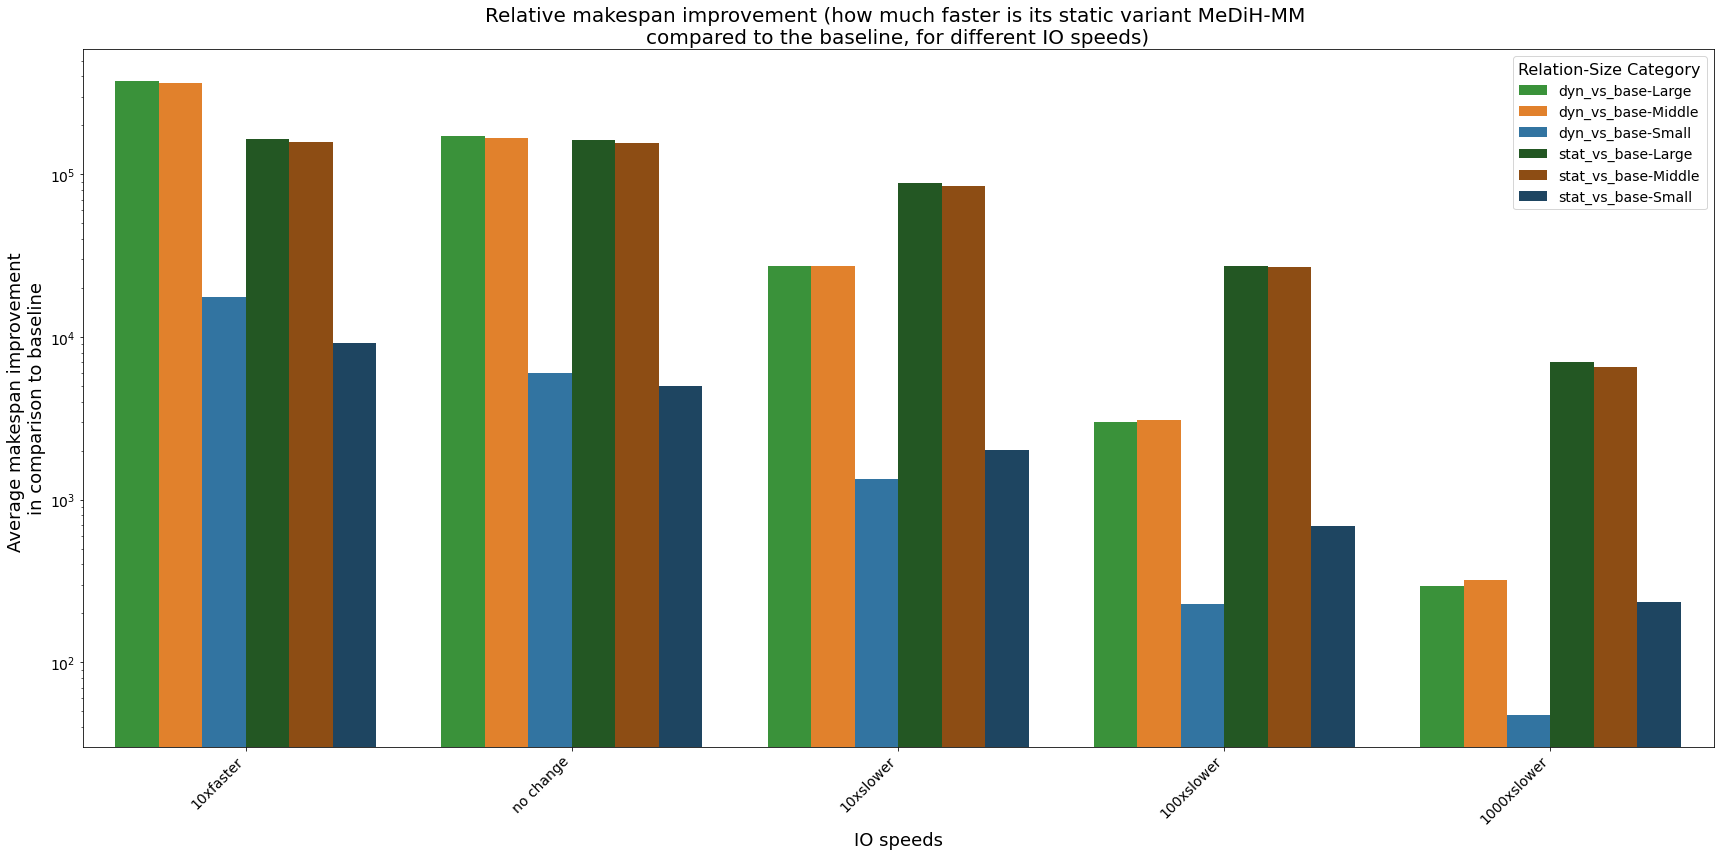

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
############ 4 #################################
         label      relation            avg
0    10xfaster   dyn_vs_base  109557.967849
1    10xfaster  stat_vs_base   51473.586800
2    no change   dyn_vs_base   43406.791580
3    no change  stat_vs_base   38905.813063
4    10xslower   dyn_vs_base    7726.791523
5    10xslower  stat_vs_base   18018.891122
6   100xslower   dyn_vs_base    1064.334212
7   100xslower  stat_vs_base    6141.030330
8  1000xslower   dyn_vs_base     141.931146
9  1000xslower  stat_vs_base    1697.810525
avg_stat_vs_base


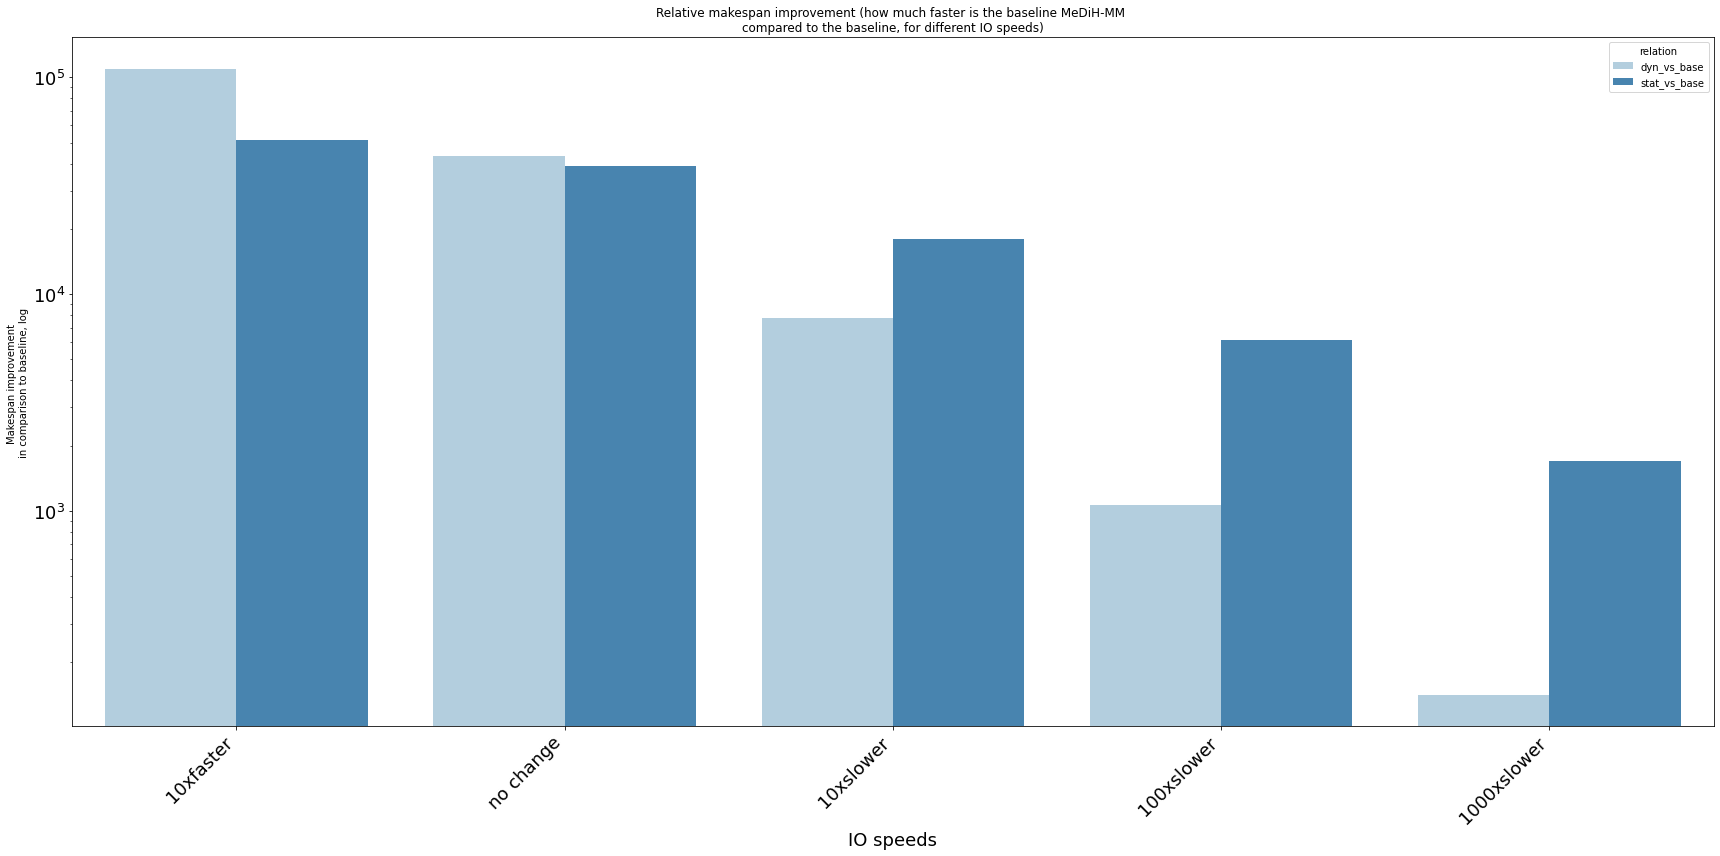

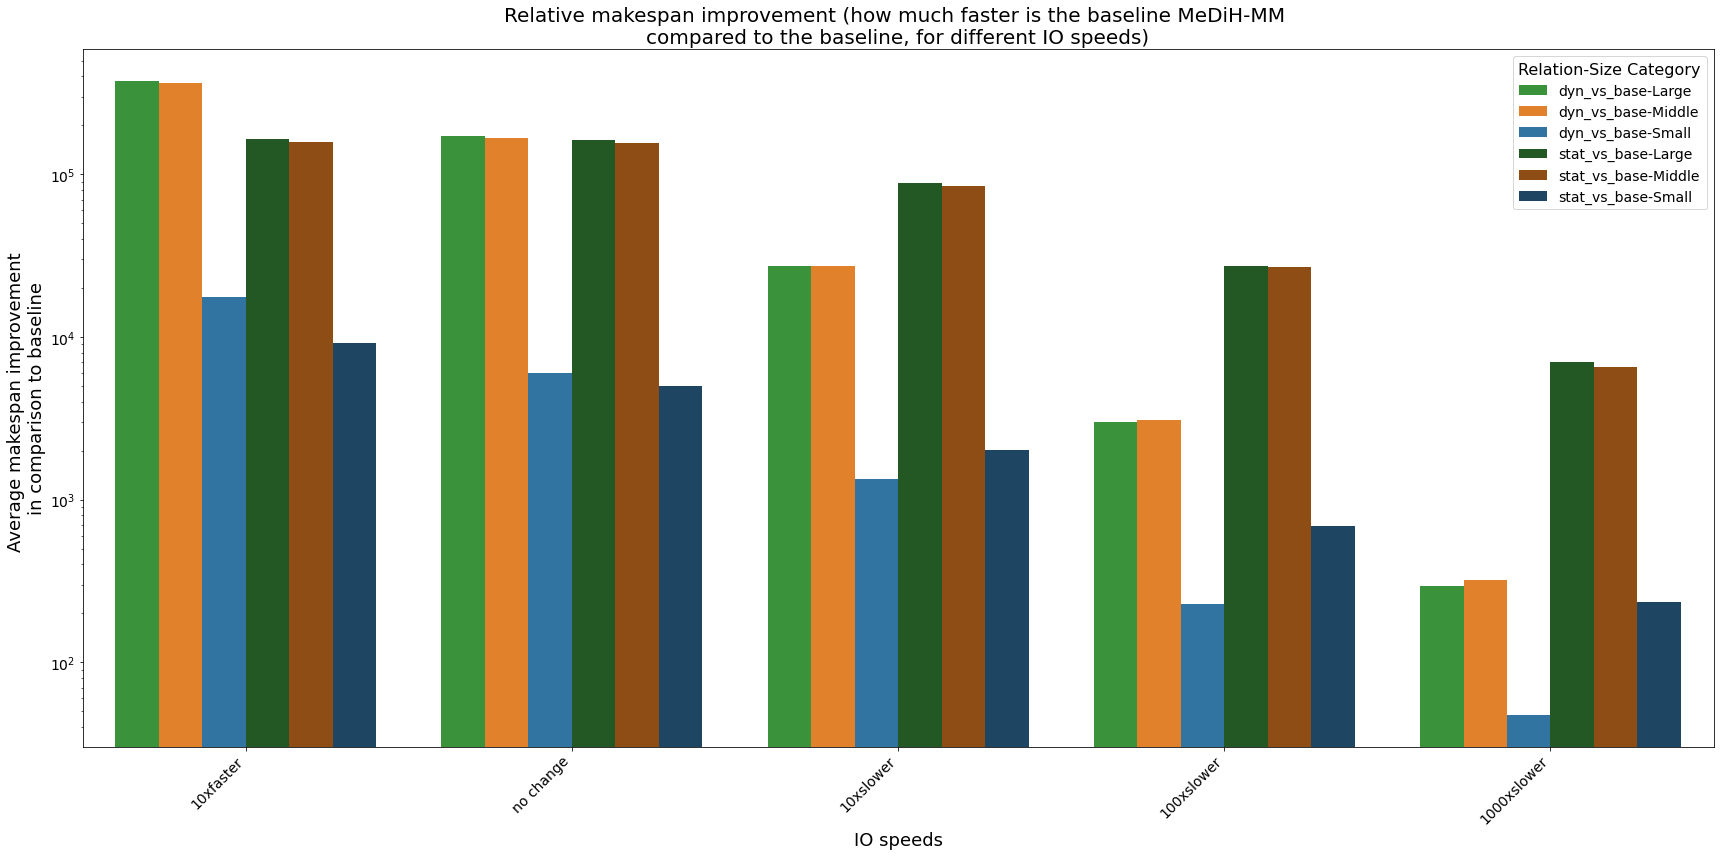

In [54]:
dfsVar3 = [dfsrw[('A3','rw100')], dfsrw[('A3','rw010')], dfsrw[('A3','rw001')], dfsrw[('A3','rw101')],
           dfsrw[('A3','rw201')]]

dfsBase = [dfsrw[('BASE','rw100')], dfsrw[('BASE','rw010')], dfsrw[('BASE','rw001')], dfsrw[('BASE','rw101')],
           dfsrw[('BASE','rw201')]]

custom_labels = ["10xfaster", "no change", "10xslower", "100xslower", "1000xslower"]
processParameterStudy(dfsVar3, dfsBase, "MeDiH-MM", "Title", custom_labels, "IO speeds", "internal")
processParameterStudy(dfsVar3, dfsBase, "MeDiH-MM", "Title", custom_labels, "IO speeds")

In [55]:
path = "./param-study-pcsp/merged/*.txt"
print(path)

patterndevs = r'^(BASE|A\d+)-ndev~(pspw\+\d)'

dfsrw=read_dfs(path,patterndevs, 2)
#print(dfsrw)

./param-study-pcsp/merged/*.txt


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
    label      relation           avg
0     10x   dyn_vs_base  42171.016391
1     10x  stat_vs_base  43951.376353
2    100x   dyn_vs_base  42089.702901
3    100x  stat_vs_base  48193.968648
4   1000x   dyn_vs_base  46773.643195
5   1000x  stat_vs_base  49404.157514
6  10000x   dyn_vs_base  45965.341324
7  10000x  stat_vs_base  48483.666402
avg_internal


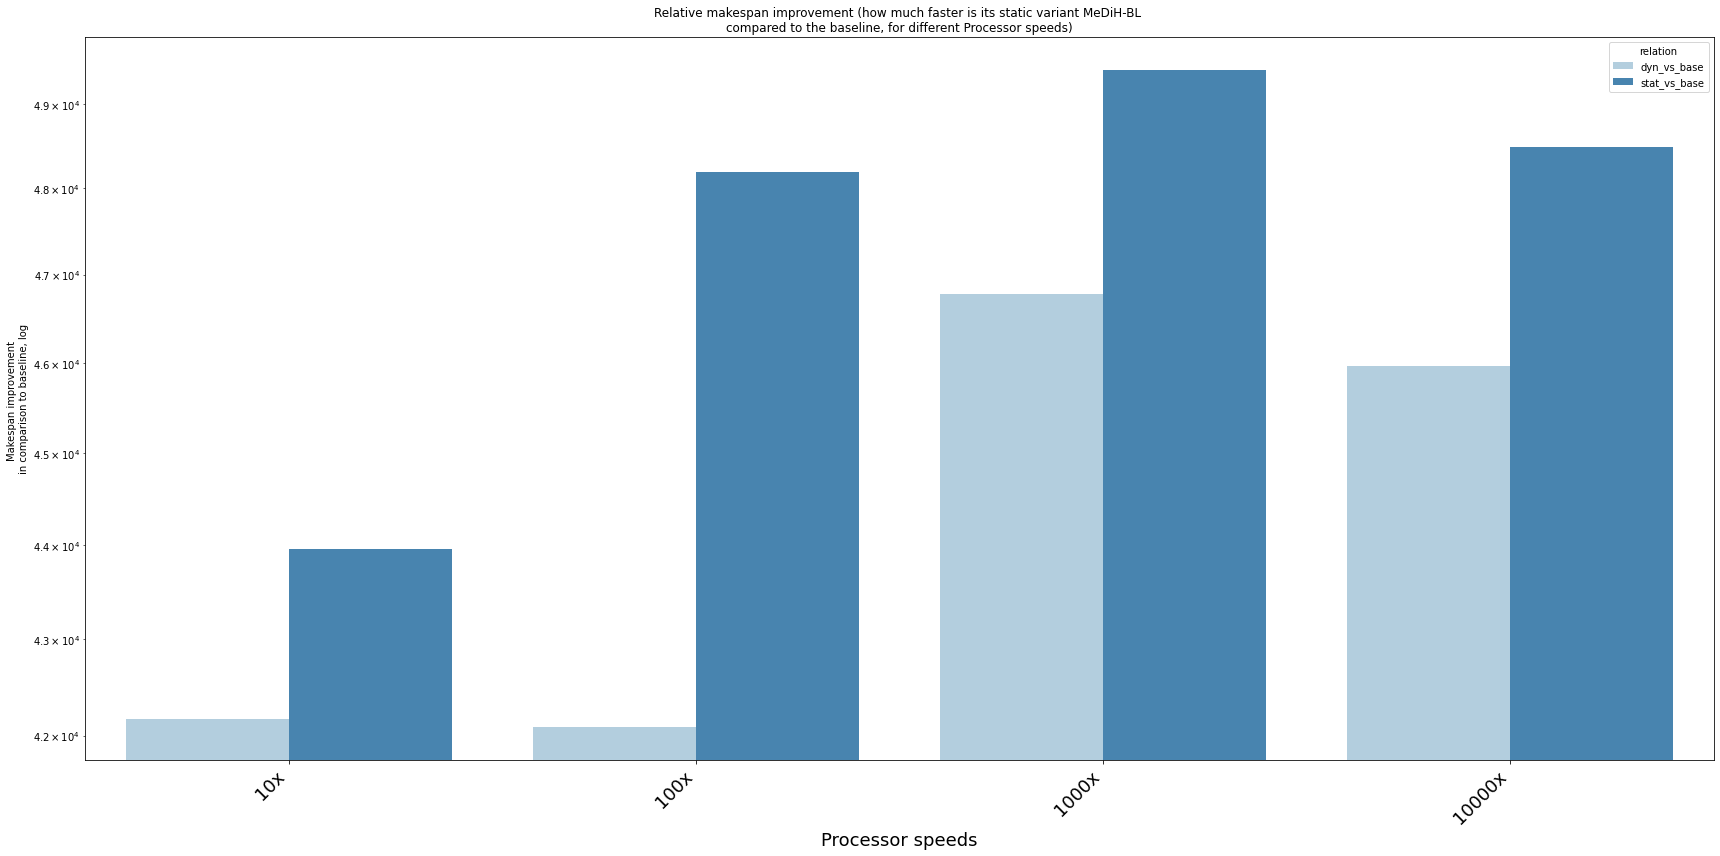

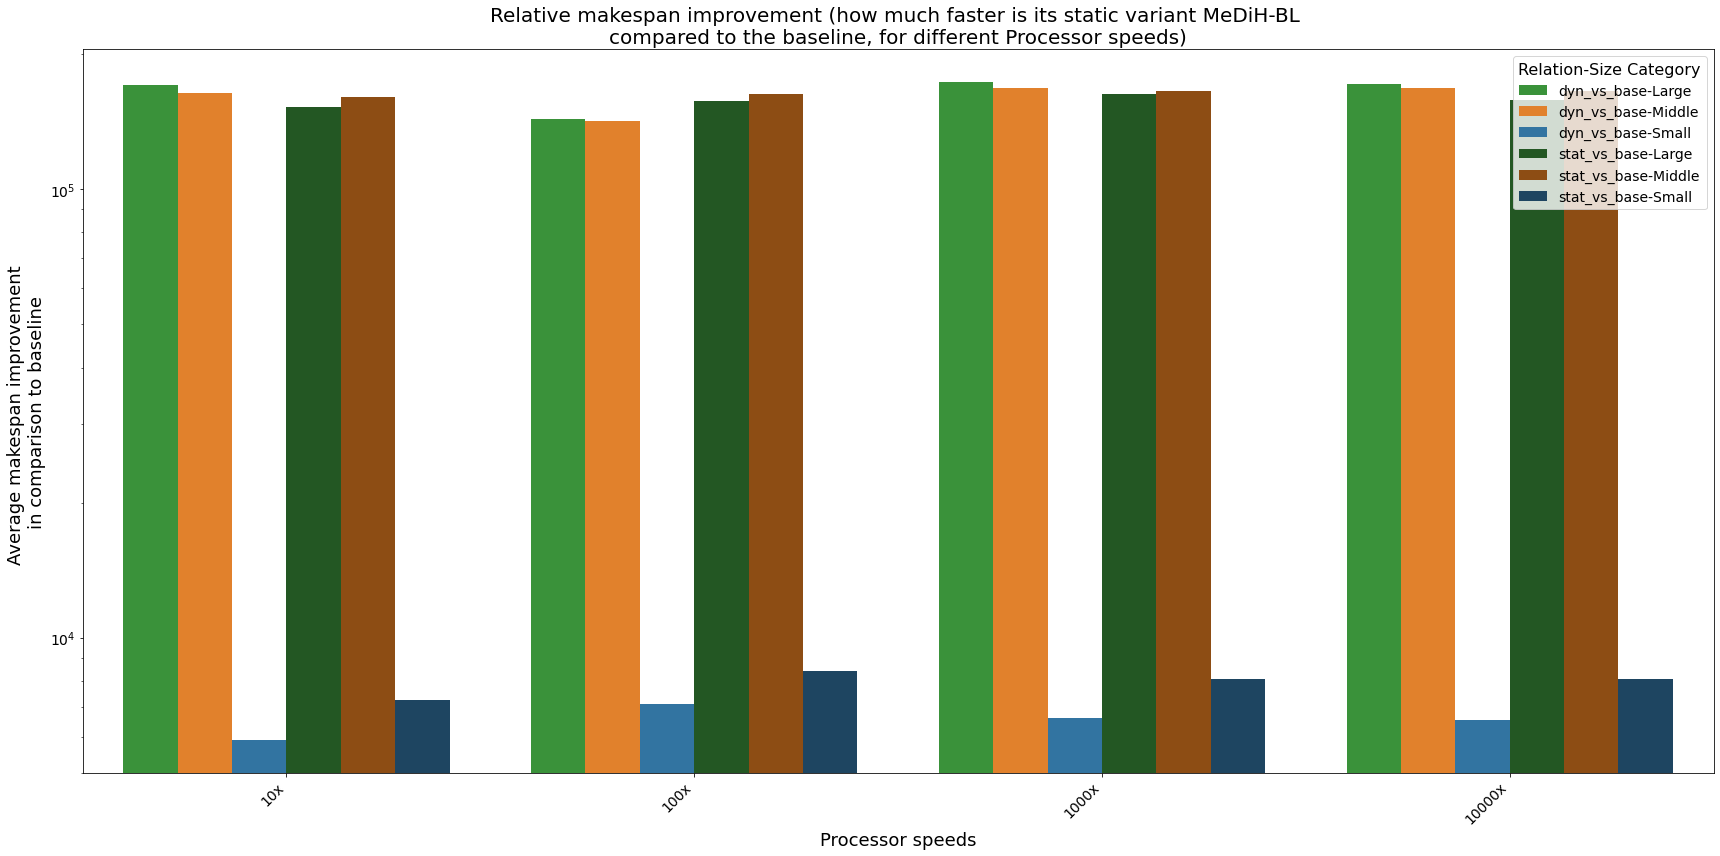

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
    label      relation           avg
0     10x   dyn_vs_base  42171.016391
1     10x  stat_vs_base  43951.376353
2    100x   dyn_vs_base  42089.702901
3    100x  stat_vs_base  48193.968648
4   1000x   dyn_vs_base  46773.643195
5   1000x  stat_vs_base  49404.157514
6  10000x   dyn_vs_base  45965.341324
7  10000x  stat_vs_base  48483.666402
avg_stat_vs_base


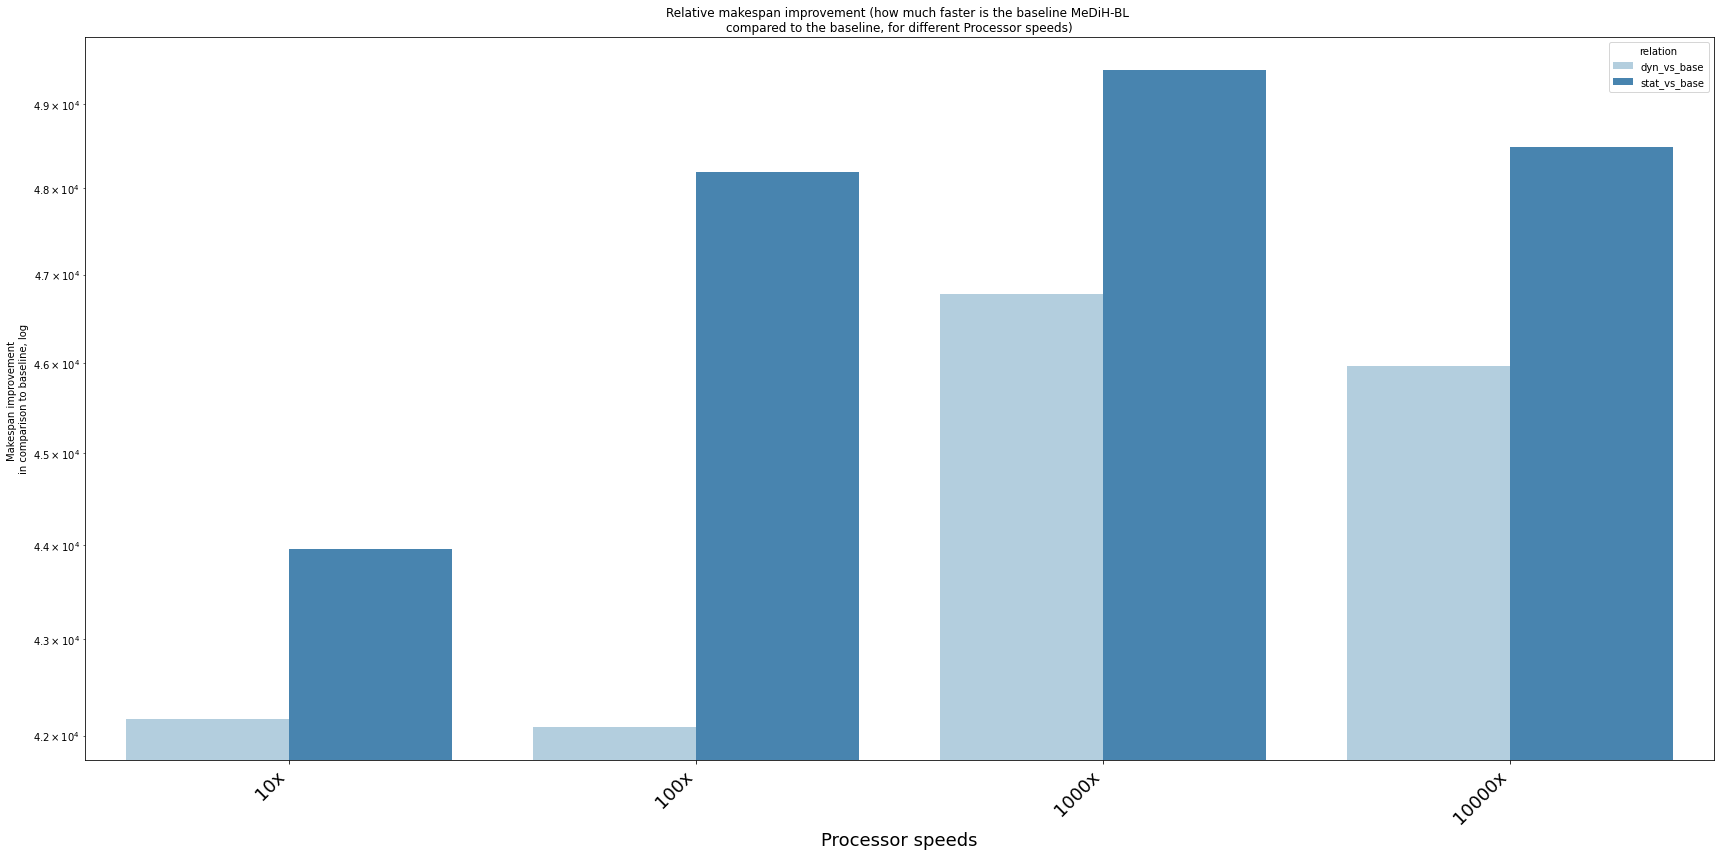

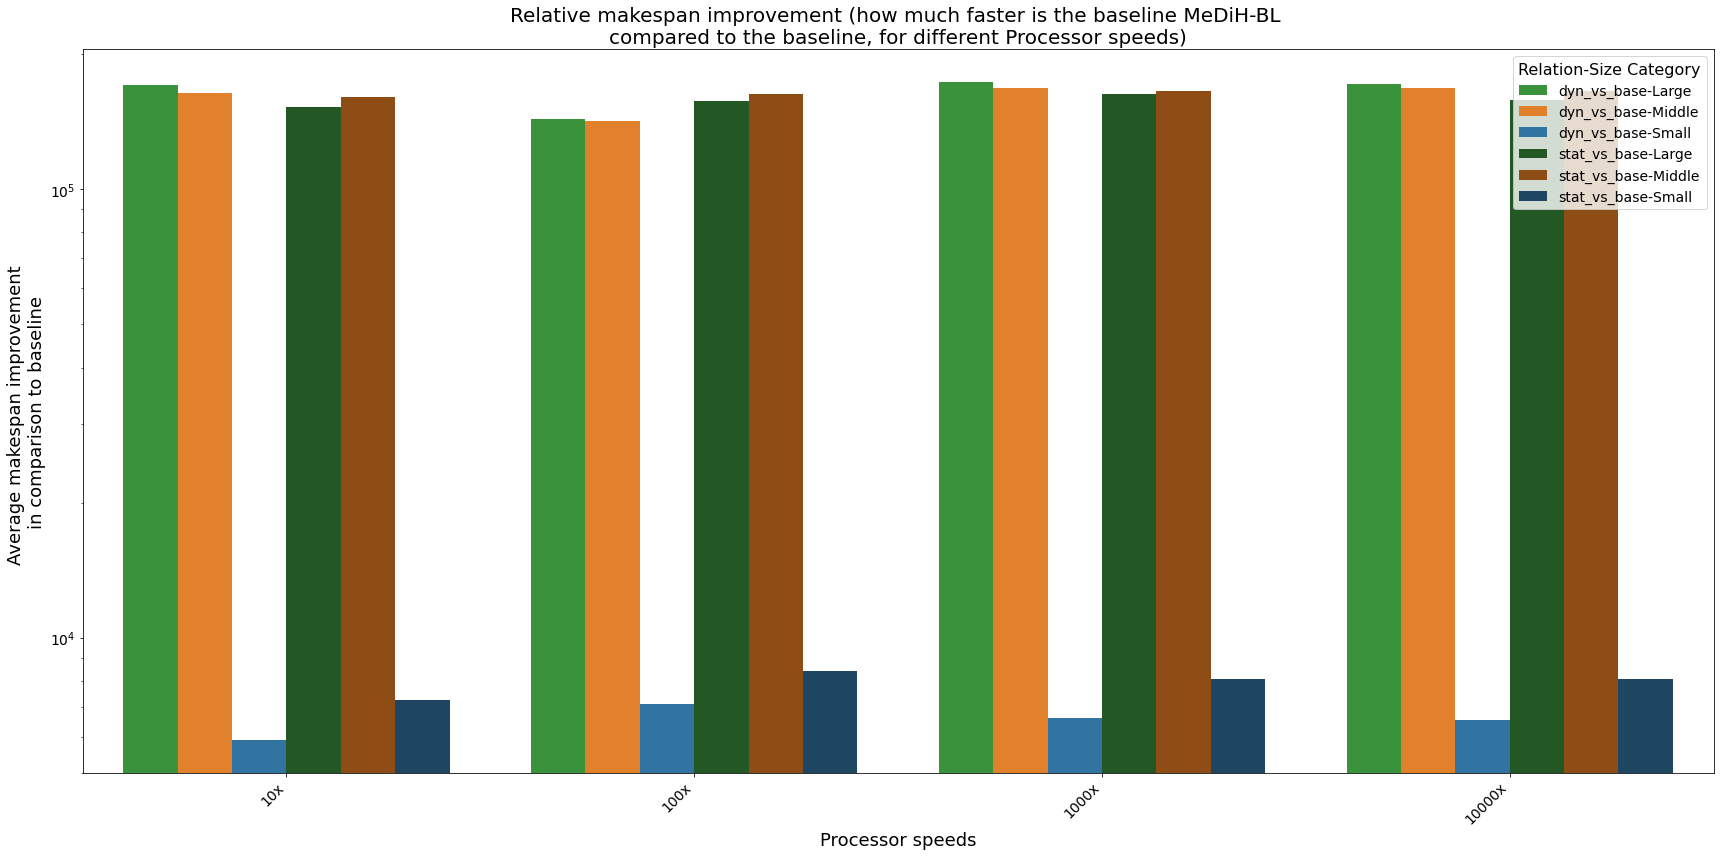

In [56]:
dfsVar1 = [dfsrw[('A1','pspw+1')], dfsrw[('A1','pspw+2')], dfsrw[('A1','pspw+3')], dfsrw[('A1','pspw+4')]]

dfsBase = [dfsrw[('BASE','pspw+1')], dfsrw[('BASE','pspw+2')], dfsrw[('BASE','pspw+3')], dfsrw[('BASE','pspw+4')]]

custom_labels = ["10x", "100x", "1000x", "10000x"]
processParameterStudy(dfsVar1, dfsBase, "MeDiH-BL", "Title", custom_labels, "Processor speeds", "internal")
processParameterStudy(dfsVar1, dfsBase, "MeDiH-BL", "Title", custom_labels, "Processor speeds")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
    label      relation           avg
0     10x   dyn_vs_base  42804.561139
1     10x  stat_vs_base  38345.337359
2    100x   dyn_vs_base  46317.719915
3    100x  stat_vs_base  41544.795407
4   1000x   dyn_vs_base  46212.474785
5   1000x  stat_vs_base  41479.243706
6  10000x   dyn_vs_base  46398.289055
7  10000x  stat_vs_base  41723.852031
avg_internal


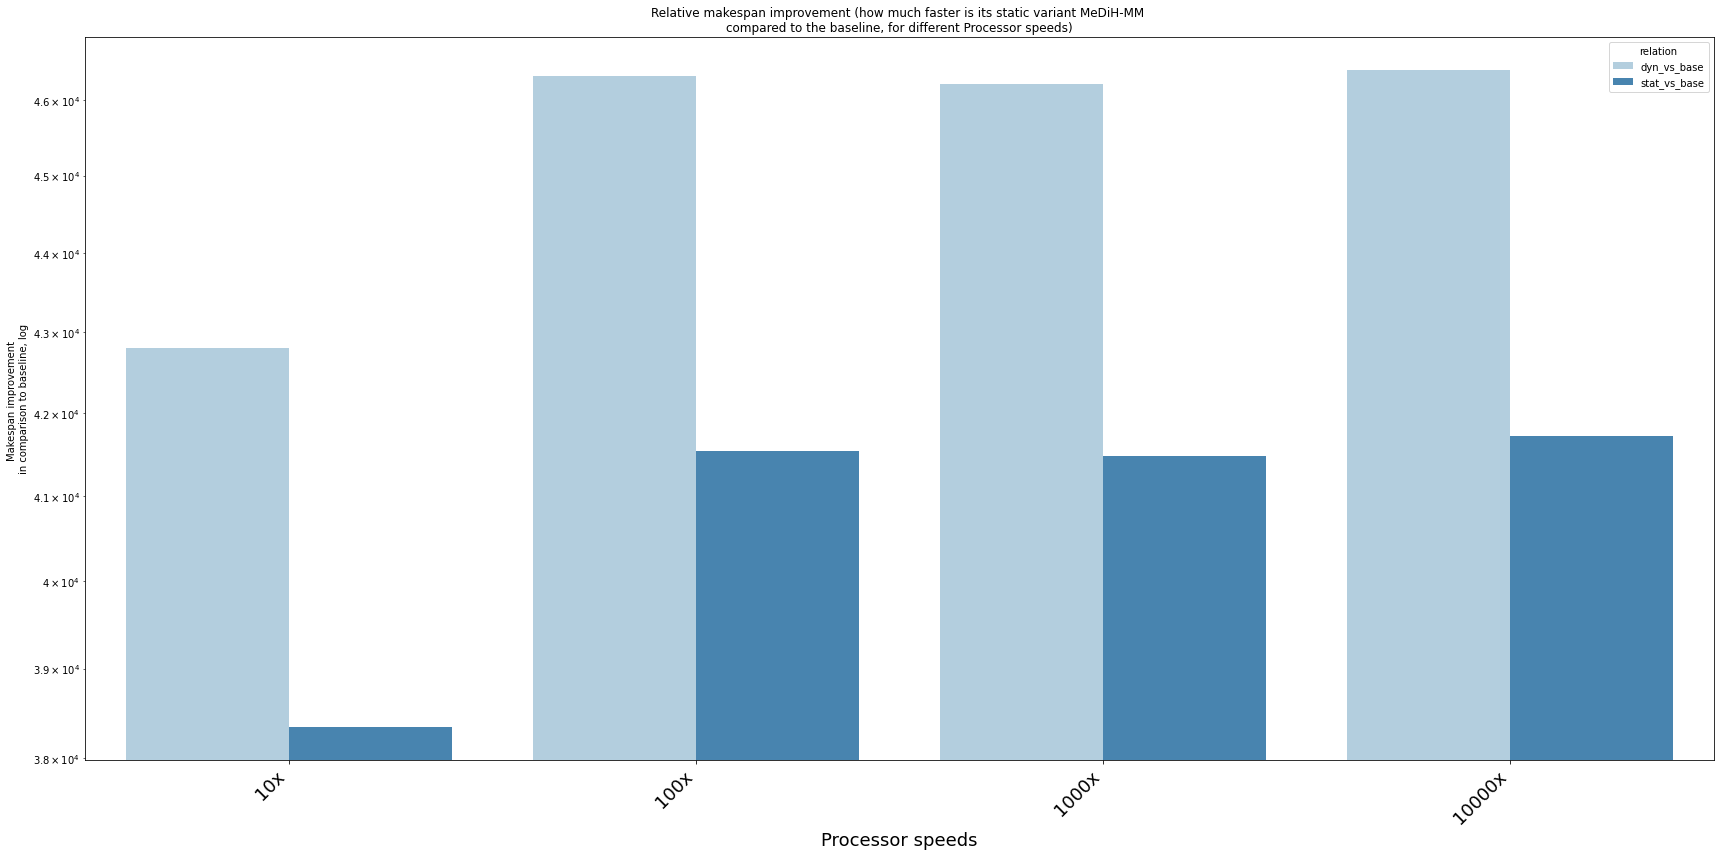

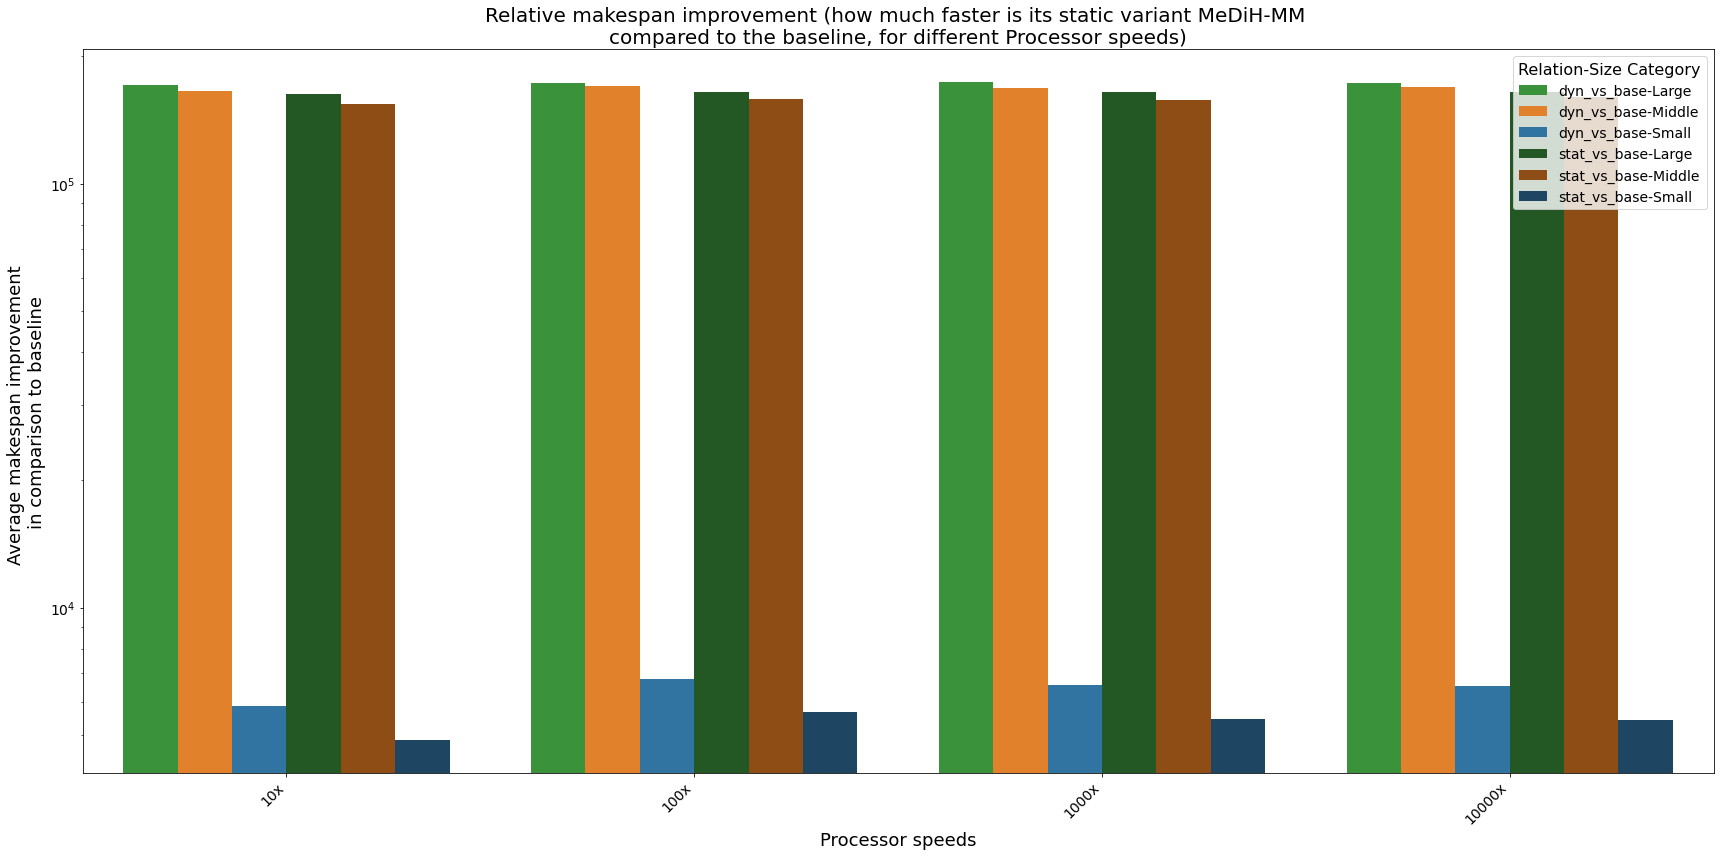

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


############ 0 #################################
############ 1 #################################
############ 2 #################################
############ 3 #################################
    label      relation           avg
0     10x   dyn_vs_base  42804.561139
1     10x  stat_vs_base  38345.337359
2    100x   dyn_vs_base  46317.719915
3    100x  stat_vs_base  41544.795407
4   1000x   dyn_vs_base  46212.474785
5   1000x  stat_vs_base  41479.243706
6  10000x   dyn_vs_base  46398.289055
7  10000x  stat_vs_base  41723.852031
avg_stat_vs_base


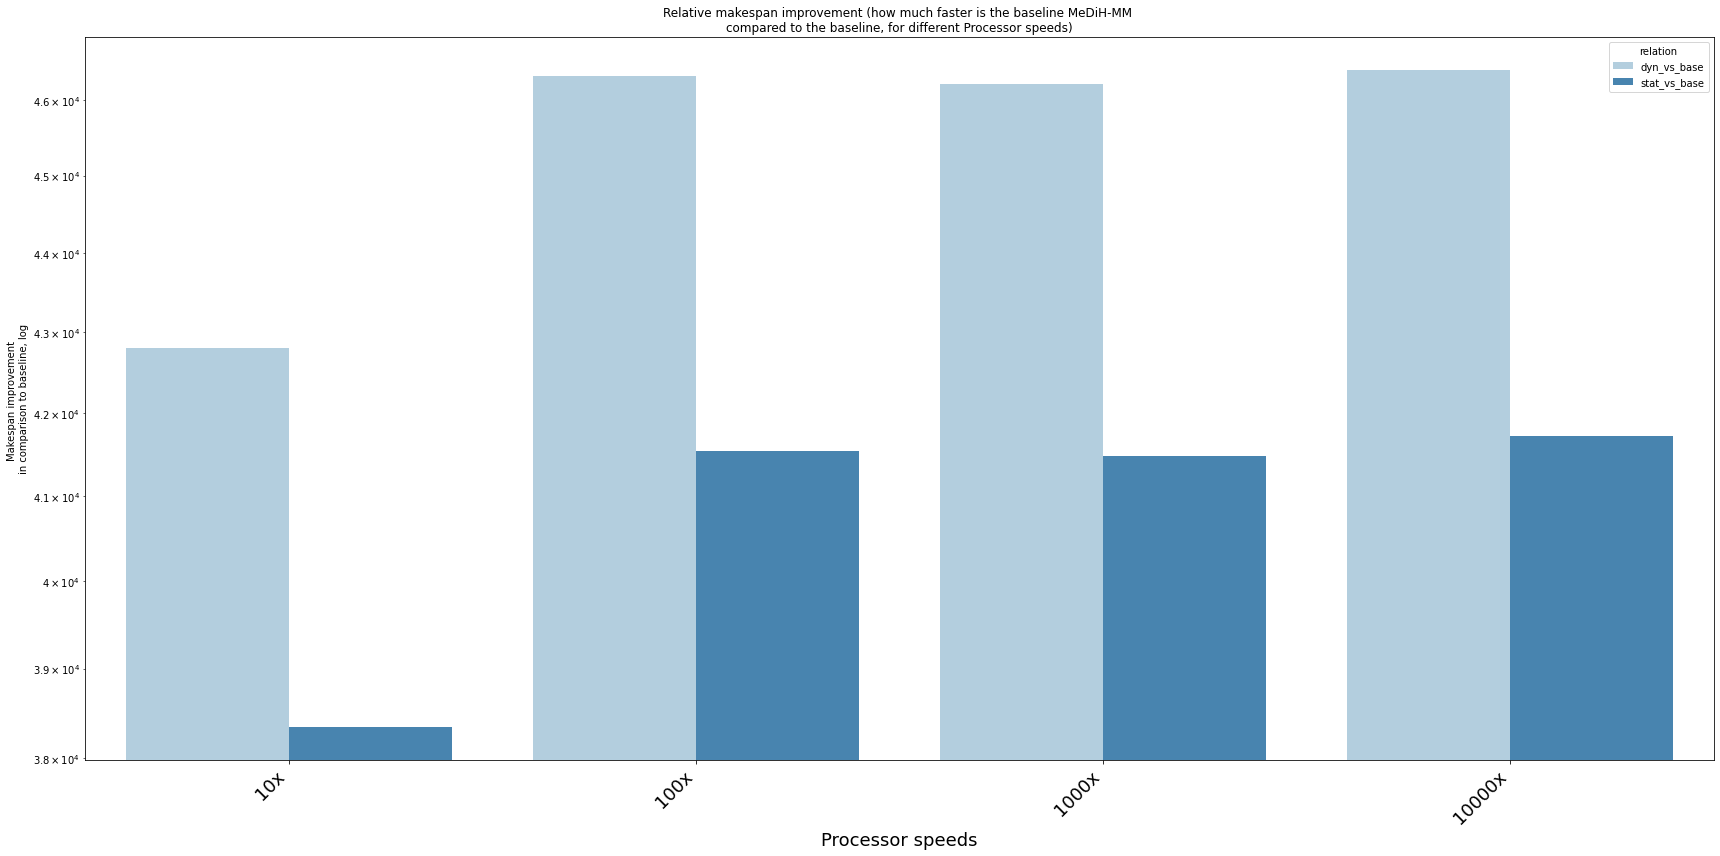

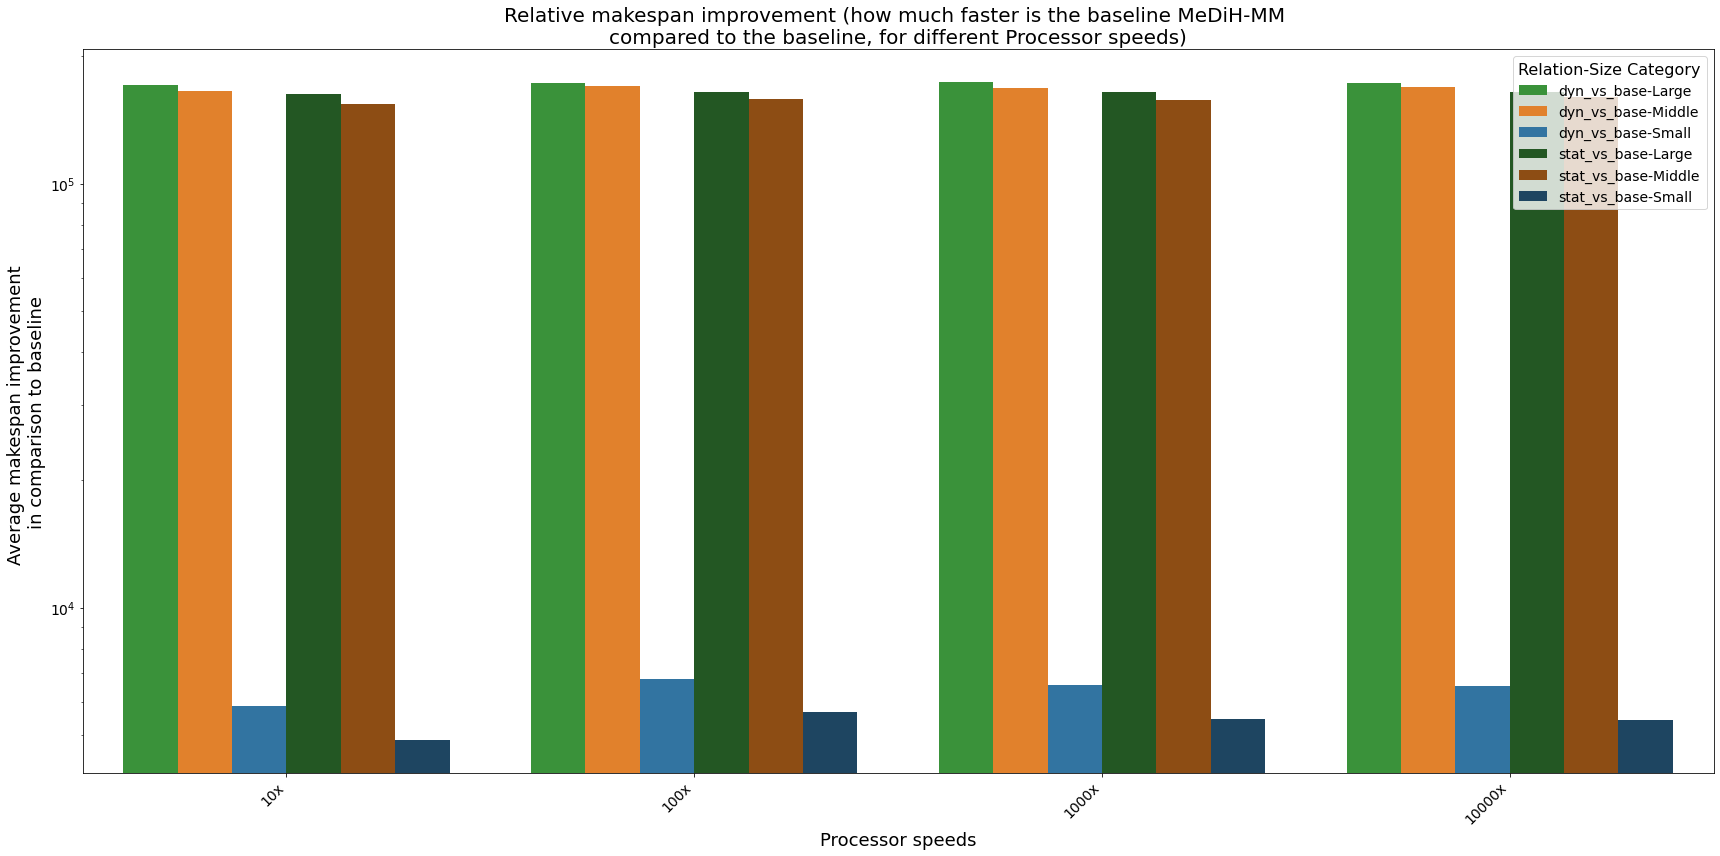

In [57]:
dfsVar1 = [dfsrw[('A3','pspw+1')], dfsrw[('A3','pspw+2')], dfsrw[('A3','pspw+3')], dfsrw[('A3','pspw+4')]]

dfsBase = [dfsrw[('BASE','pspw+1')], dfsrw[('BASE','pspw+2')], dfsrw[('BASE','pspw+3')], dfsrw[('BASE','pspw+4')]]

custom_labels = ["10x", "100x", "1000x", "10000x"]
processParameterStudy(dfsVar1, dfsBase, "MeDiH-MM", "Title", custom_labels, "Processor speeds","internal")
processParameterStudy(dfsVar1, dfsBase, "MeDiH-MM", "Title", custom_labels, "Processor speeds")

In [58]:
path = "./real-exps-correctparams/merged/*.txt"
print(path)

patterndevs = r'^(BASE|A\d+)-(\d\ddev)'

dfs=read_dfs(path,patterndevs, 2)
#print(dfs)

./real-exps-correctparams/merged/*.txt


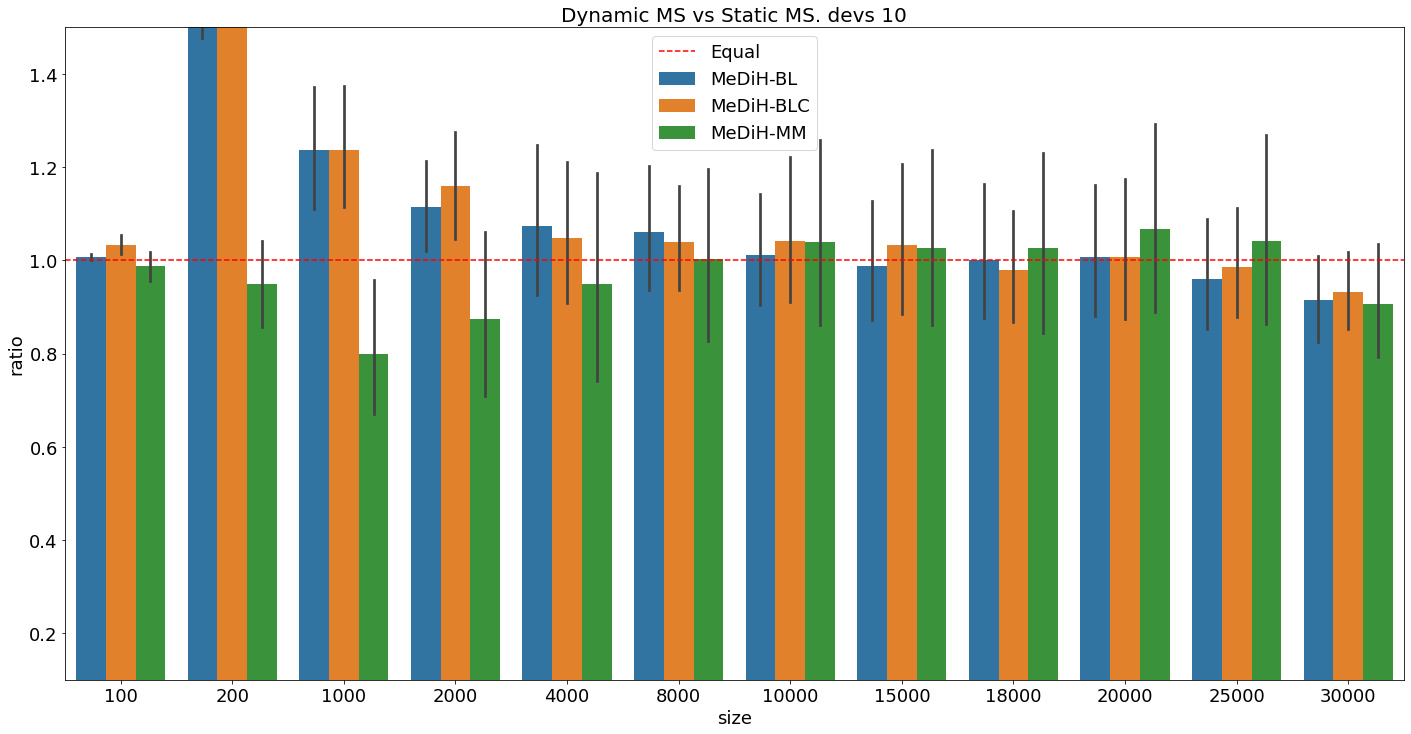

In [59]:
#dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar1 = [dfs[('A1','10dev')], dfs[('A2','10dev')], dfs[('A3','10dev')], dfs[('BASE','10dev')]]
merged_df_var1 = merge_correct_columns(dfsVar1, labels)
#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var1)
#print(plot_df.head())

plt.figure(figsize=(24, 12))

internal_df = plot_df[plot_df['relation'] == 'internal']
sns.barplot(data = internal_df, x = 'size', y ='ratio', hue = 'algorithm') 
baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')

plt.ylim(0.1, 1.5)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('size', fontsize=18)
plt.ylabel('ratio', fontsize=18)
plt.legend(fontsize=18)  
plt.title('Dynamic MS vs Static MS. devs 10', fontsize=20)

plt.show()

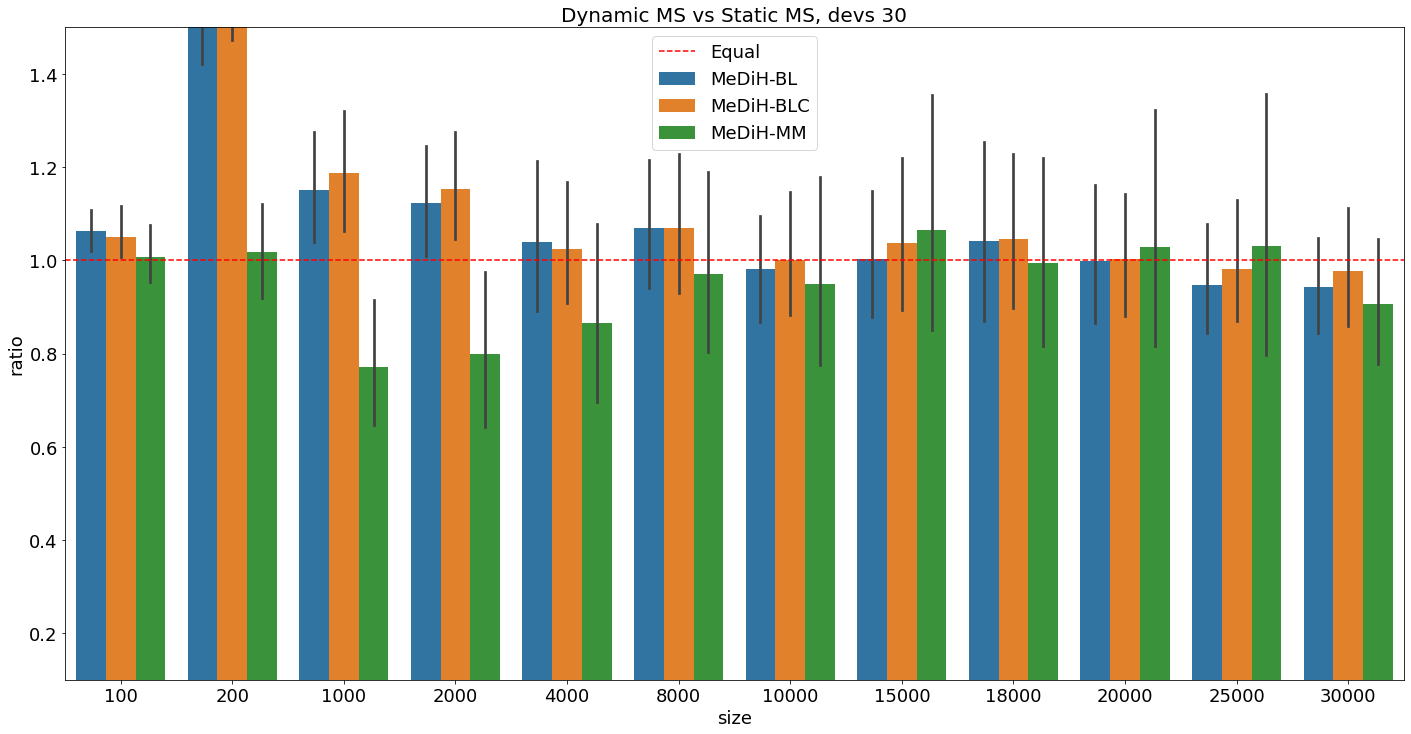

In [19]:
#dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar2 = [dfs[('A1','30dev')], dfs[('A2','30dev')], dfs[('A3','30dev')], dfs[('BASE','30dev')]]
merged_df_var2 = merge_correct_columns(dfsVar2, labels)
#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var2)
#print(plot_df.head())

plt.figure(figsize=(24, 12))

internal_df = plot_df[plot_df['relation'] == 'internal']
sns.barplot(data = internal_df, x = 'size', y ='ratio', hue = 'algorithm') 
baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')

plt.ylim(0.1, 1.5)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('size', fontsize=18)
plt.ylabel('ratio', fontsize=18)
plt.legend(fontsize=18)  
plt.title('Dynamic MS vs Static MS, devs 30', fontsize=20)

plt.show()

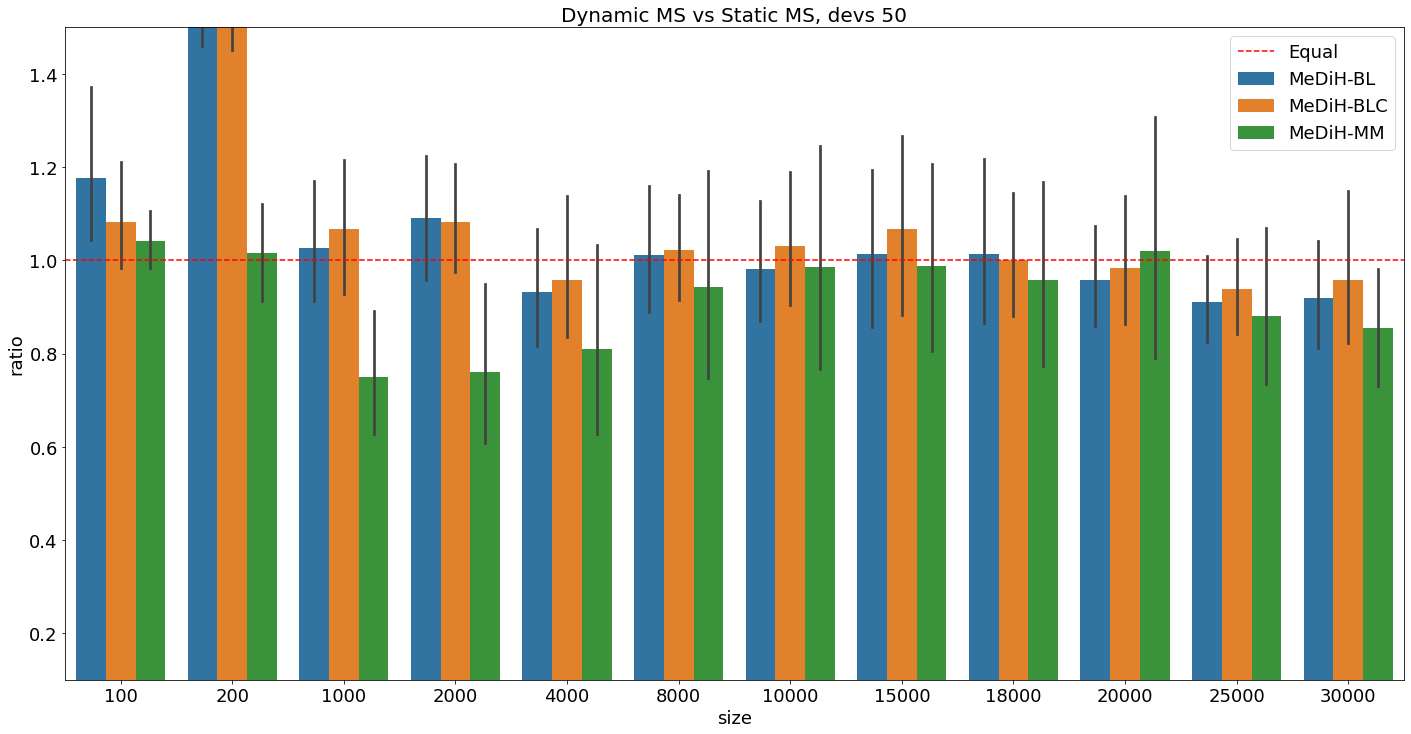

In [60]:
#dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar3 = [dfs[('A1','50dev')], dfs[('A2','50dev')], dfs[('A3','50dev')], dfs[('BASE','50dev')]]
merged_df_var3 = merge_correct_columns(dfsVar3, labels)
#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var3)
#print(plot_df.head())

plt.figure(figsize=(24, 12))

internal_df = plot_df[plot_df['relation'] == 'internal']
sns.barplot(data = internal_df, x = 'size', y ='ratio', hue = 'algorithm') 
baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')

plt.ylim(0.1, 1.5)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('size', fontsize=18)
plt.ylabel('ratio', fontsize=18)
plt.legend(fontsize=18)  
plt.title('Dynamic MS vs Static MS, devs 50', fontsize=20)

plt.show()

In [21]:
#print(plot_df)
#print(plot_df[plot_df['size']>25000])
print(plot_df[(plot_df['size']>25000) & (plot_df['relation']=="internal")])

       size              wf_name  relation     ratio algorithm
0     30000    atacseq_30000.dot  internal  0.814058  MeDiH-BL
10    30000    atacseq_30000.dot  internal  0.835865  MeDiH-BL
17    30000  methylseq_30000.dot  internal  0.722123  MeDiH-BL
25    30000    atacseq_30000.dot  internal  1.028307  MeDiH-BL
28    30000    atacseq_30000.dot  internal  0.812451  MeDiH-BL
...     ...                  ...       ...       ...       ...
1816  30000      eager_30000.dot  internal  1.005188  MeDiH-MM
1822  30000    chipseq_30000.dot  internal  1.381062  MeDiH-MM
1866  30000      eager_30000.dot  internal  1.025648  MeDiH-MM
1868  30000    chipseq_30000.dot  internal  0.745560  MeDiH-MM
1890  30000    chipseq_30000.dot  internal  0.507896  MeDiH-MM

[66 rows x 5 columns]


./param-study-pcsp/merged/*.txt
     size  algorithm     ratio
0     100   MeDiH-BL  1.011165
1     100  MeDiH-BLC  1.011165
2     100   MeDiH-MM  0.960107
3     200   MeDiH-BL  1.371893
4     200  MeDiH-BLC  1.371893
5     200   MeDiH-MM  0.956890
6    1000   MeDiH-BL  1.200728
7    1000  MeDiH-BLC  1.200728
8    1000   MeDiH-MM  0.736318
9    2000   MeDiH-BL  1.187348
10   2000  MeDiH-BLC  1.187348
11   2000   MeDiH-MM  0.783853
12   4000   MeDiH-BL  1.080934
13   4000  MeDiH-BLC  1.080934
14   4000   MeDiH-MM  0.824635
15   8000   MeDiH-BL  1.268644
16   8000  MeDiH-BLC  1.268644
17   8000   MeDiH-MM  0.906306
18  10000   MeDiH-BL  1.087037
19  10000  MeDiH-BLC  1.087037
20  10000   MeDiH-MM  0.943864
21  15000   MeDiH-BL  1.079542
22  15000  MeDiH-BLC  1.079542
23  15000   MeDiH-MM  0.952657
24  18000   MeDiH-BL  1.099520
25  18000  MeDiH-BLC  1.099520
26  18000   MeDiH-MM  0.988715
27  20000   MeDiH-BL  1.115557
28  20000  MeDiH-BLC  1.115557
29  20000   MeDiH-MM  0.986323
30  250

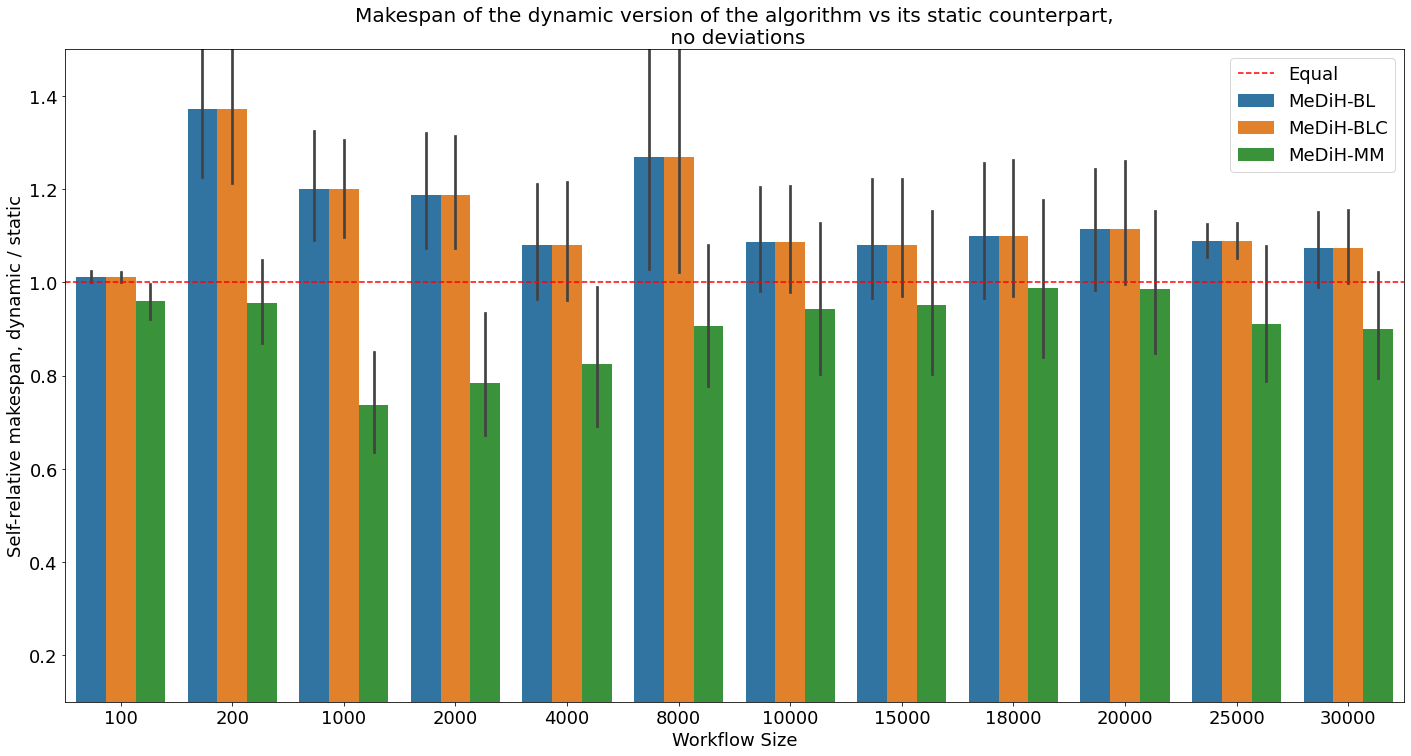

In [22]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!A2 IST A1!!!!!!!!!!!!!!!!!!!!!!!!!!!!
path = "./param-study-pcsp/merged/*.txt"
print(path)
from scipy.stats import gmean

patterndevs = r'^(BASE|A\d+)-ndev~(pspw\+\d)'

dfsrw=read_dfs(path,patterndevs, 2)
#print(dfsrw)
#dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar3 = [dfsrw[('A1','pspw+2')], dfsrw[('A1','pspw+2')], dfsrw[('A3','pspw+2')], dfsrw[('BASE','pspw+2')]]
merged_df_var3 = merge_correct_columns(dfsVar3, labels)
#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var3)
#print(plot_df.head())

plt.figure(figsize=(24, 12))

internal_df = plot_df[plot_df['relation'] == 'internal']

sns.barplot(data = internal_df, x = 'size', y ='ratio', hue = 'algorithm', estimator=gmean)  #, est=gmean
baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')




grouped = internal_df.groupby(['size', 'algorithm'])['ratio'].agg(safe_gmean).reset_index()
# Print the values used for bar heights
print(grouped)

gr = grouped.groupby(['algorithm'])['ratio'].agg(np.mean)
print(gr)

for name, group in internal_df.groupby(['size', 'algorithm']):
    if (group['ratio'] <= 0).any():
        print(f"Group {name} contains non-positive values:", group['ratio'].tolist())


plt.ylim(0.1, 1.5)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('Workflow Size', fontsize=18)
plt.ylabel('Self-relative makespan, dynamic / static', fontsize=18)
plt.legend(fontsize=18)  
plt.title('Makespan of the dynamic version of the algorithm vs its static counterpart,\n no deviations', fontsize=20)
plt.savefig("static-vs-dynamic-no-devs.png", dpi=300, bbox_inches='tight')
plt.show()

In [23]:
import random
path = "./real-exps-correctparams/merged_minmodified/*.txt"
print(path)

patterndevs = r'^(BASE|A\d+)-(\d\ddev)'

dfs=read_dfs(path,patterndevs, 2)
#print(dfs)

for (algorithm, variant), df in dfs.items():
    df['ms_1'] = pd.to_numeric(df['ms_1'], errors='raise')
    start=0.7
    end=0.9
    if variant=="30dev":
        start=0.4
    if variant=="50dev":
        start=0.3  
    random_multipliers = np.random.uniform(start, end, size=len(df))
    #print(df['ms_1'])
    #if algorithm!= "A3":
    df['ms_1']= df['ms_1']* random_multipliers
    df.to_csv(f"modified_{algorithm}_{variant}.csv")
    #print(df['ms_1'])
    
#dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar1 = [dfs[('A1','10dev')], dfs[('A2','10dev')], dfs[('A3','10dev')], dfs[('BASE','10dev')]]
merged_df_var1 = merge_correct_columns(dfsVar1, labels)
#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var1)
#print(plot_df.head())

plt.figure(figsize=(24, 12))

internal_df = plot_df[plot_df['relation'] == 'internal']
sns.barplot(data = internal_df, x = 'size', y ='ratio', hue = 'algorithm', estimator=gmean) 
baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')

plt.ylim(0.1, 1.5)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('Workflow Size', fontsize=18)
plt.ylabel('Self-relative makespan, dynamic / static', fontsize=18)
plt.legend(fontsize=18)  
plt.title('Makespan of the dynamic version of the algorithm vs its static counterpart,\n deviations 10%', fontsize=20)
plt.savefig("static-vs-dynamic-10-devs.png", dpi=300, bbox_inches='tight')
plt.show()


def safe_gmean(x):
    x = np.array(x)
    x = x[x > 0]  # only positive values
    return gmean(x) if len(x) > 0 else np.nan

grouped = internal_df.groupby(['size', 'algorithm'])['ratio'].agg(safe_gmean).reset_index()
# Print the values used for bar heights
print(grouped)

gr = grouped.groupby(['algorithm'])['ratio'].agg(np.mean)
print(gr)



#dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar3 = [dfs[('A1','30dev')], dfs[('A2','30dev')], dfs[('A3','30dev')], dfs[('BASE','30dev')]]
merged_df_var3 = merge_correct_columns(dfsVar3, labels)
#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var3)
#print(plot_df.head())

plt.figure(figsize=(24, 12))

internal_df = plot_df[plot_df['relation'] == 'internal']
sns.barplot(data = internal_df, x = 'size', y ='ratio', hue = 'algorithm', estimator=gmean) 
baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')

plt.ylim(0.1, 1.5)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('Workflow Size', fontsize=18)
plt.ylabel('Self-relative makespan, dynamic / static', fontsize=18)
plt.legend(fontsize=18)  
plt.title('Makespan of the dynamic version of the algorithm vs its static counterpart,\n deviations 30%', fontsize=20)
plt.savefig("static-vs-dynamic-30-devs.png", dpi=300, bbox_inches='tight')
plt.show()

grouped = internal_df.groupby(['size', 'algorithm'])['ratio'].agg(safe_gmean).reset_index()
# Print the values used for bar heights
print(grouped)

gr = grouped.groupby(['algorithm'])['ratio'].agg(np.mean)
print(gr)

#dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar3 = [dfs[('A1','50dev')], dfs[('A2','50dev')], dfs[('A3','50dev')], dfs[('BASE','50dev')]]
merged_df_var3 = merge_correct_columns(dfsVar3, labels)
#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var3)
#print(plot_df.head())

plt.figure(figsize=(24, 12))

internal_df = plot_df[plot_df['relation'] == 'internal']
sns.barplot(data = internal_df, x = 'size', y ='ratio', hue = 'algorithm', estimator=gmean) 
baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')

plt.ylim(0.1, 1.5)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('Workflow Size', fontsize=18)
plt.ylabel('Self-relative makespan, dynamic / static', fontsize=18)
plt.legend(fontsize=18)  
plt.title('Makespan of the dynamic version of the algorithm vs its static counterpart,\n deviations 50%', fontsize=20)
plt.savefig("static-vs-dynamic-50-devs.png", dpi=300, bbox_inches='tight')
plt.show()

grouped = internal_df.groupby(['size', 'algorithm'])['ratio'].agg(safe_gmean).reset_index()
# Print the values used for bar heights
print(grouped)
gr = grouped.groupby(['algorithm'])['ratio'].agg(np.mean)
print(gr)


./real-exps-correctparams/merged_minmodified/*.txt


KeyError: ('A1', '10dev')

In [ ]:
#path = "./real-exps-correctparams/merged_modified/*.txt"
path = "./real-exps-correctparams/merged_minmodified/*.txt"
print(path)

#patterndevs = r'^modified_(BASE|A\d+)_(\d\ddev)'
patterndevs = r'^(BASE|A\d+)-(\d\ddev)'


def draw3InternalWins(pathToRead, patterns):
    dfs=read_dfs(pathToRead,patterns, 2)
    #print(dfs)


    #dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
    labels = ['A1', 'A2', 'A3', 'BASE']
    dfsVar1 = [dfs[('A1','10dev')], dfs[('A2','10dev')], dfs[('A3','10dev')], dfs[('BASE','10dev')]]
    merged_df_var1 = merge_correct_columns(dfsVar1, labels)
    #print(merged_df_var1)
    plot_df = buld_plot_df(merged_df_var1)
    #print(plot_df.head())

    plt.figure(figsize=(24, 12))

    internal_df = plot_df[plot_df['relation'] == 'internal']
    sns.barplot(data = internal_df, x = 'size', y ='ratio', hue = 'algorithm') 
    baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')

    plt.ylim(0.1, 1.5)

    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.xlabel('size', fontsize=18)
    plt.ylabel('ratio', fontsize=18)
    plt.legend(fontsize=18)  
    plt.title('Dynamic MS vs Static MS. devs 10', fontsize=20)

    plt.show()
    
    def safe_gmean(x):
        x = np.array(x)
        x = x[x > 0]  # only positive values
        return gmean(x) if len(x) > 0 else np.nan

    grouped = internal_df.groupby(['size', 'algorithm'])['ratio'].agg(safe_gmean).reset_index()
    # Print the values used for bar heights
    print(grouped)





    #dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
    labels = ['A1', 'A2', 'A3', 'BASE']
    dfsVar3 = [dfs[('A1','30dev')], dfs[('A2','30dev')], dfs[('A3','30dev')], dfs[('BASE','30dev')]]
    merged_df_var3 = merge_correct_columns(dfsVar3, labels)
    #print(merged_df_var1)
    plot_df = buld_plot_df(merged_df_var3)
    #print(plot_df.head())

    plt.figure(figsize=(24, 12))

    internal_df = plot_df[plot_df['relation'] == 'internal']
    sns.barplot(data = internal_df, x = 'size', y ='ratio', hue = 'algorithm') 
    baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')

    plt.ylim(0.1, 1.5)

    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.xlabel('size', fontsize=18)
    plt.ylabel('ratio', fontsize=18)
    plt.legend(fontsize=18)  
    plt.title('Dynamic MS vs Static MS, devs 50', fontsize=20)

    plt.show()




    #dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
    labels = ['A1', 'A2', 'A3', 'BASE']
    dfsVar3 = [dfs[('A1','50dev')], dfs[('A2','50dev')], dfs[('A3','50dev')], dfs[('BASE','50dev')]]
    merged_df_var3 = merge_correct_columns(dfsVar3, labels)
    #print(merged_df_var1)
    plot_df = buld_plot_df(merged_df_var3)
    #print(plot_df.head())

    plt.figure(figsize=(24, 12))

    internal_df = plot_df[plot_df['relation'] == 'internal']
    sns.barplot(data = internal_df, x = 'size', y ='ratio', hue = 'algorithm') 
    baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')

    plt.ylim(0.1, 1.5)

    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.xlabel('size', fontsize=18)
    plt.ylabel('ratio', fontsize=18)
    plt.legend(fontsize=18)  
    plt.title('Dynamic MS vs Static MS, devs 50', fontsize=20)

    plt.show()

draw3InternalWins(path, patterndevs)

In [12]:

#path = "./real-exps-correctparams/merged_modified/*.txt"
path = "./real-exps-correctparams/merged_minmodified/*.txt"
print(path)

#patterndevs = r'^modified_(BASE|A\d+)_(\d\ddev)'
patterndevs = r'^(BASE|A\d+)-(\d\ddev)'

dfs=read_dfs(path,patterndevs, 2)

labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar1 = [dfs[('A1','10dev')], dfs[('A2','10dev')], dfs[('A3','10dev')], dfs[('BASE','10dev')]]
merged_df_var1 = merge_correct_columns(dfsVar1, labels)
#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var1)

plot_df["family"]= plot_df['wf_name'].apply(lambda x: x.split('_') [0])
print(plot_df)

plt.figure(figsize=(24, 12))

internal_df = plot_df[plot_df['relation'] == 'internal']
internal_df = internal_df[internal_df['algorithm'] == 'MeDiH-BL']

grouped = internal_df.groupby(['family', 'size'], as_index=False)['ratio'].mean()
 

#sns.scatterplot(data=grouped, x="size", y='ratio', hue='family', palette='tab10')

# Plot with lines and larger dots
sns.lineplot(data=grouped, x='size', y='ratio', hue='family', palette='tab10', marker='o', linewidth=1.5)

# Enlarge the dots manually by plotting scatter on top
sns.scatterplot(data=grouped, x='size', y='ratio', hue='family', palette='tab10', s=100, legend=False)


baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')

plt.ylim(0.1, 1.5)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('size', fontsize=18)
plt.ylabel('ratio', fontsize=18)
plt.legend(fontsize=18)  
plt.title('Dynamic MS vs Static MS, devs 10', fontsize=20)

plt.show()

./real-exps-correctparams/merged_minmodified/*.txt


KeyError: ('A1', '10dev')

In [4]:
#path = "./real-exps-correctparams/merged_modified/*.txt"
path = "./real-exps-correctparams/merged_minmodified/*.txt"
print(path)

#patterndevs = r'^modified_(BASE|A\d+)_(\d\ddev)'
patterndevs = r'^(BASE|A\d+)-(\d\ddev)'

dfs=read_dfs(path,patterndevs, 2)
#print(dfs)


#dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar1 = [dfs[('A1','10dev')], dfs[('A2','10dev')], dfs[('A3','10dev')], dfs[('BASE','10dev')]]
merged_df_var1 = merge_correct_columns(dfsVar1, labels)

#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var1)
plot_df["family"]= plot_df['wf_name'].apply(lambda x: x.split('_') [0])
print(plot_df)

./real-exps-correctparams/merged_minmodified/*.txt


NameError: name 'read_dfs' is not defined

In [ ]:
import matplotlib.colors as mcolors

def plotFamilies(plot_df_given, percentage):
    # Filter data
    algosCorrectNames = ['MeDiH-BL', 'MeDiH-BLC', 'MeDiH-MM']
    internal_df = plot_df_given[(plot_df_given['relation'] == 'internal') & (plot_df_given['algorithm'].isin(algosCorrectNames))]
    
    #print(internal_df[(internal_df['algorithm']=='MeDiH-BLC') & (internal_df['family']=='methylseq')
    #                 & (internal_df['ratio']>1)
    #                 ])
    
    # Group by algorithm, family, size and average ratio
   # grouped = internal_df.groupby(['algorithm', 'family', 'size'], as_index=False)['ratio'].mean()
    grouped = internal_df.groupby(['algorithm', 'family', 'size'], as_index=False).agg({'ratio': gmean})

    # Get unique families and base colors
    families = grouped['family'].unique()
    base_palette = dict(zip(families, sns.color_palette("tab10", n_colors=len(families))))

    # Function to darken a color (reduce lightness)
    def darken_color(color, amount=0.6):
        c = mcolors.to_rgb(color)
        return tuple(max(min(x * amount, 1), 0) for x in c)

    # Create a palette mapping (family, algorithm) -> color shade
    algo_shade_map = {
        'MeDiH-BL': 1.0, #1.0,   # base (medium)
        'MeDiH-BLC': 1.0, # 0.8,  # darker
        'MeDiH-MM': 1.0 #0.6    # darkest
    }

    palette = {}
    for family in families:
        base_color = base_palette[family]
        for algo in algosCorrectNames:
            shade = algo_shade_map[algo]
            palette[(family, algo)] = darken_color(base_color, amount=shade)
    
    marker_map = {
        'MeDiH-BL': 'o',   # circle
        'MeDiH-BLC': 's',  # square
        'MeDiH-MM': '^'    # diamond
    }
    linestyle_map = {
    'MeDiH-BL': 'dashdot',      # or '-'
    'MeDiH-BLC': 'dashed',    # or '--'
    'MeDiH-MM': 'dotted',     # or ':'
    }


    # Create a new column combining family and algorithm for plotting
    grouped['fam_algo'] = grouped.apply(lambda row: f"{row['family']} ({row['algorithm']})", axis=1)

    plt.figure(figsize=(24, 12))

    for fam_algo, data in grouped.groupby('fam_algo'):
        family, algo = fam_algo.split(' (')
        algo = algo[:-1]  # remove trailing ')'
        color = palette[(family, algo)]
        marker = marker_map[algo]
        lnst=linestyle_map[algo]

       # print(fam_algo, data)
        # Plot line
        plt.plot(
            data['size'], data['ratio'], marker=None,
            color=color,
            linewidth=2,
            label=fam_algo,
            linestyle=lnst,
        )

        # Plot larger dots on top
        plt.scatter(
            data['size'], data['ratio'],
            s=120,  # bigger size
            color=color,
            marker=marker,
            edgecolor='black',  # optional: add black edge for better visibility
            linewidth=0.7,
            zorder=5
        )
    baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')
    
    plt.xlabel('Size')
    plt.ylabel('Average Ratio')
    plt.title(f'Makespan of the dynamic version of the algorithm vs its static counterpart,\n by workflow families, deviations {percentage}')
    plt.legend(title='Family (Algorithm)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"families-{percentage}-devs.png", dpi=300, bbox_inches='tight')
    plt.show()

plotFamilies(plot_df, "10%")

In [40]:
#path = "./real-exps-correctparams/merged_modified/*.txt"
path = "./real-exps-correctparams/merged_final/*.txt"
print(path)

#patterndevs = r'^modified_(BASE|A\d+)_(\d\ddev)'
patterndevs = r'^(BASE|A\d+)-(\d\ddev)'

dfs=read_dfs(path,patterndevs, 2)
#print(dfs)


#dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar1 = [dfs[('A1','30dev')], dfs[('A2','30dev')], dfs[('A3','30dev')], dfs[('BASE','30dev')]]
merged_df_var1 = merge_correct_columns(dfsVar1, labels)

#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var1)
plot_df["family"]= plot_df['wf_name'].apply(lambda x: x.split('_') [0])
plotFamilies(plot_df,"30%")

./real-exps-correctparams/merged_final/*.txt


NameError: name 'plotFamilies' is not defined

In [3]:

#dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar1 = [dfs[('A1','50dev')], dfs[('A2','50dev')], dfs[('A3','50dev')], dfs[('BASE','50dev')]]
merged_df_var1 = merge_correct_columns(dfsVar1, labels)

#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var1)
plot_df["family"]= plot_df['wf_name'].apply(lambda x: x.split('_') [0])
plotFamilies(plot_df, "50%")

NameError: name 'dfs' is not defined

In [41]:
#path = "./real-exps-correctparams/merged_modified/*.txt"
path = "./real-exps-correctparams/merged_final/*.txt"
print(path)

#patterndevs = r'^modified_(BASE|A\d+)_(\d\ddev)'
patterndevs = r'^(BASE|A\d+)-(\d\ddev)'

dfs=read_dfs(path,patterndevs, 2)
#print(dfs)


#dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar1 = [dfs[('A1','10dev')], dfs[('A2','10dev')], dfs[('A3','10dev')], dfs[('BASE','10dev')]]
merged_df_var1 = merge_correct_columns(dfsVar1, labels)
print(merged_df_var1)
#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var1)

./real-exps-correctparams/merged_final/*.txt
                 wf_name     inp_size       ms_1_A1       ms_2_A1  \
0      atacseq_30000.dot  14091675276  1.608916e+09  1.926565e+09   
1      chipseq_15000.dot  41366257414  3.693793e+09  4.795073e+09   
2    methylseq_15000.dot   6761426956  1.225026e+08  1.481743e+08   
3      atacseq_15000.dot   3908761308  2.554478e+08  2.357231e+08   
4                  eager  19075314980  6.316005e+06  6.098430e+06   
..                   ...          ...           ...           ...   
269                eager  19132169434  6.147436e+06  5.977221e+06   
270  methylseq_10000.dot  17027257018  3.133972e+08  4.396889e+08   
271        eager_200.dot   8330435694  6.614669e+06  3.315246e+06   
272  methylseq_18000.dot  22500260922  8.861897e+08  1.119443e+09   
273    chipseq_10000.dot   4807293396  2.000774e+08  2.397300e+08   

          ms_1_A2       ms_2_A2       ms_1_A3       ms_2_A3     ms_1_BASE  \
0    1.613671e+09  1.874412e+09  1.602935e+09  2.

In [35]:
#print(merged_df_var1)
#print(merged_df_var1)
print(plot_df)

       size              wf_name      relation          ratio algorithm
0     30000    atacseq_30000.dot      internal       0.835122  MeDiH-BL
1     15000    chipseq_15000.dot      internal       0.770331  MeDiH-BL
2     15000  methylseq_15000.dot      internal       0.826746  MeDiH-BL
3     15000    atacseq_15000.dot      internal       1.083677  MeDiH-BL
4       100                eager      internal       1.035677  MeDiH-BL
...     ...                  ...           ...            ...       ...
2461    100                eager  stat_vs_base       1.058825  MeDiH-MM
2462  10000  methylseq_10000.dot  stat_vs_base   13833.508561  MeDiH-MM
2463    200        eager_200.dot  stat_vs_base       0.482270  MeDiH-MM
2464  18000  methylseq_18000.dot  stat_vs_base   62605.145073  MeDiH-MM
2465  10000    chipseq_10000.dot  stat_vs_base  888412.864912  MeDiH-MM

[2466 rows x 5 columns]


filtered_df
        size              wf_name     inp_size  relation     ratio algorithm  \
0     30000    atacseq_30000.dot  14091675276  internal  0.835122  MeDiH-BL   
1     15000    chipseq_15000.dot  41366257414  internal  0.770331  MeDiH-BL   
2     15000  methylseq_15000.dot   6761426956  internal  0.826746  MeDiH-BL   
3     15000    atacseq_15000.dot   3908761308  internal  1.083677  MeDiH-BL   
4       100                eager  19075314980  internal  1.035677  MeDiH-BL   
...     ...                  ...          ...       ...       ...       ...   
1920    100                eager  19132169434  internal  1.084687  MeDiH-MM   
1921  10000  methylseq_10000.dot  17027257018  internal  1.307127  MeDiH-MM   
1922    200        eager_200.dot   8330435694  internal  1.001203  MeDiH-MM   
1923  18000  methylseq_18000.dot  22500260922  internal  1.380266  MeDiH-MM   
1924  10000    chipseq_10000.dot   4807293396  internal  0.883146  MeDiH-MM   

                  alg_rel  
0     MeDi

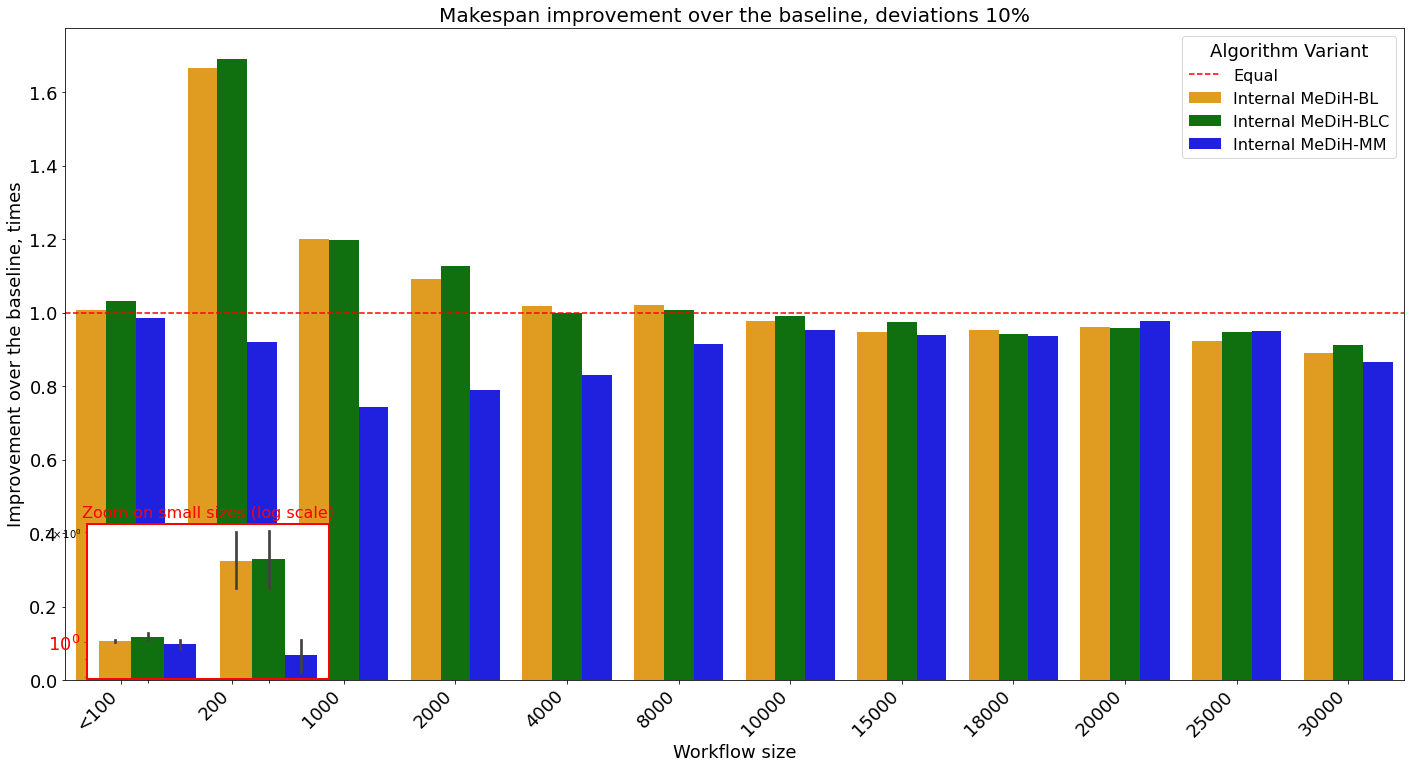

     size               alg_rel     ratio
0     100   MeDiH-BL - internal  1.007268
1     100  MeDiH-BLC - internal  1.032852
2     100   MeDiH-MM - internal  0.985519
3     200   MeDiH-BL - internal  1.665762
4     200  MeDiH-BLC - internal  1.691806
5     200   MeDiH-MM - internal  0.919244
6    1000   MeDiH-BL - internal  1.199476
7    1000  MeDiH-BLC - internal  1.199005
8    1000   MeDiH-MM - internal  0.743048
9    2000   MeDiH-BL - internal  1.091267
10   2000  MeDiH-BLC - internal  1.126395
11   2000   MeDiH-MM - internal  0.789248
12   4000   MeDiH-BL - internal  1.018413
13   4000  MeDiH-BLC - internal  0.999710
14   4000   MeDiH-MM - internal  0.831527
15   8000   MeDiH-BL - internal  1.020985
16   8000  MeDiH-BLC - internal  1.006229
17   8000   MeDiH-MM - internal  0.914965
18  10000   MeDiH-BL - internal  0.978451
19  10000  MeDiH-BLC - internal  0.992369
20  10000   MeDiH-MM - internal  0.953134
21  15000   MeDiH-BL - internal  0.948062
22  15000  MeDiH-BLC - internal  0

In [102]:
#df_plot = merged_df_var1[['size', 'ms_1_A1', 'ms_1_A2', 'ms_1_A3']].copy()

# Step 2: Melt to long format
#df_long = df_plot.melt(id_vars='size', 
#                       value_vars=['ms_1_A1', 'ms_1_A2', 'ms_1_A3'],
#                       var_name='Algorithm', 
#                       value_name='Makespan')

# Optional: Clean up algorithm names
#df_long['Algorithm'] = df_long['Algorithm'].str.replace('ms_1_', '')

def plotDynAndStaticVsBase(our_df, deviationsText):

    #filtered_df = our_df[our_df['relation'].isin(['stat_vs_base', 'dyn_vs_base'])].copy()
    filtered_df = our_df[our_df['relation'].isin(['internal'])].copy()
    filtered_df['alg_rel'] = filtered_df['algorithm'] + ' - ' + filtered_df['relation']
    print("filtered_df\n", filtered_df)

    fig, ax = plt.subplots(figsize=(24, 12))
    ax = sns.barplot(
        data=filtered_df,
        x='size',
        y='ratio',
        hue='alg_rel',
        estimator=gmean,
        palette=palette,
        ci=None
    )
    baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')
    #ax.set_yscale("log")
    plt.xticks(rotation=45)
    #plt.ylim(80000, 200000)

    #plt.tight_layout()

    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.xlabel('Workflow size', fontsize=18)
    plt.ylabel('Improvement over the baseline, times', fontsize=18)
    plt.legend(fontsize=18)  


    # Get current tick labels and modify them
    xticks = ax.get_xticks()
    xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

    # Replace label "100" with "<100"
    new_labels = ["<100" if lbl == "100" else lbl for lbl in xticklabels]

    # Apply the modified labels
    ax.set_xticklabels(new_labels, fontsize=18, rotation=45, ha='right')

    handles, labels = ax.get_legend_handles_labels()

    # Apply the mapping
    pretty_labels = [label_map.get(lbl, lbl) for lbl in labels]

    
    # Set updated legend
    ax.legend(handles, pretty_labels, title="Algorithm Variant", fontsize=16, title_fontsize=18)
    plt.title(f'Makespan improvement over the baseline, {deviationsText}', fontsize=20)


    #inset_ax = inset_axes(ax, width="40%", height="45%", loc='upper left',
    #                      bbox_to_anchor=(0.1, 0.55, 0.4, 0.4), bbox_transform=fig.transFigure)
    inset_ax = inset_axes(ax,
                          width="35%", height="45%", loc='lower left',
                          bbox_to_anchor=(0.135, 0.12, 0.4, 0.4),  # <-- lower position
                          bbox_transform=fig.transFigure)

    # Filter for small sizes (100 and 200)
    small_df = filtered_df[filtered_df['size'].isin([100, 200])]

    sns.barplot(data=small_df, x='size', y='ratio', hue='alg_rel', ax=inset_ax, estimator=gmean,  palette=palette,)
    inset_ax.set_yscale("log")  # Show small differences better
    inset_ax.set_title("Zoom on small sizes (log scale)", fontsize=16, color='red')
    inset_ax.tick_params(axis='both', labelsize=18)
    inset_ax.set_xlabel("")
    inset_ax.set_ylabel("")
    inset_ax.set_xticklabels([])
    inset_ax.tick_params(axis='y', colors='red')

    for spine in inset_ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2)  # Adjust thickness as needed

    # Optionally draw a rectangle to highlight the zoomed region
    # from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    # mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5")

    # Clean up legend (show only one)
    #ax.legend(title="Algorithm Variant", fontsize=16, title_fontsize=16)
    inset_ax.get_legend().remove()

   

    plt.savefig(f'improv_ov_baseline_newest_{deviationsText}.png', facecolor='white')
    plt.show()

    grouped = filtered_df.groupby(['size', 'alg_rel'])['ratio'].agg(safe_gmean).reset_index()
    # Print the values used for bar heights
    print(grouped)

    gr = grouped.groupby(['alg_rel'])['ratio'].agg(np.mean)
    print(gr)

plotDynAndStaticVsBase(plot_df, "deviations 10%")

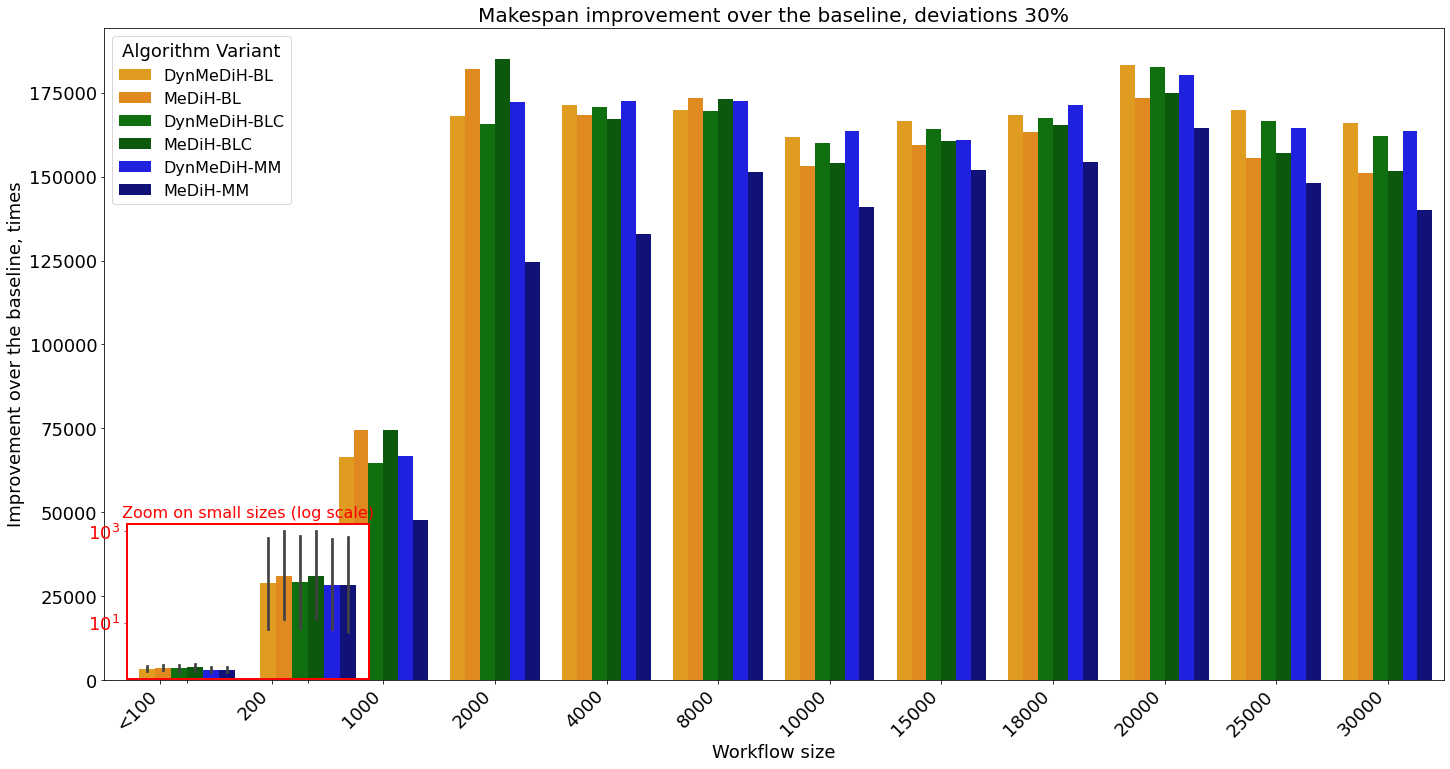

     size                   alg_rel          ratio
0     100    MeDiH-BL - dyn_vs_base       0.974259
1     100   MeDiH-BL - stat_vs_base       1.031636
2     100   MeDiH-BLC - dyn_vs_base       0.998511
3     100  MeDiH-BLC - stat_vs_base       1.044201
4     100    MeDiH-MM - dyn_vs_base       0.939415
..    ...                       ...            ...
67  30000   MeDiH-BL - stat_vs_base  151085.094718
68  30000   MeDiH-BLC - dyn_vs_base  162139.930678
69  30000  MeDiH-BLC - stat_vs_base  151829.020279
70  30000    MeDiH-MM - dyn_vs_base  163551.376701
71  30000   MeDiH-MM - stat_vs_base  139973.118095

[72 rows x 3 columns]
alg_rel
MeDiH-BL - dyn_vs_base      132674.338728
MeDiH-BL - stat_vs_base     129557.238159
MeDiH-BLC - dyn_vs_base     131188.676989
MeDiH-BLC - stat_vs_base    130352.320696
MeDiH-MM - dyn_vs_base      132400.780605
MeDiH-MM - stat_vs_base     113092.767400
Name: ratio, dtype: float64


In [33]:
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar2 = [dfs[('A1','30dev')], dfs[('A2','30dev')], dfs[('A3','30dev')], dfs[('BASE','30dev')]]
merged_df_var2 = merge_correct_columns(dfsVar2, labels)

#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var2)
plotDynAndStaticVsBase(plot_df, "deviations 30%")

In [92]:
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar3 = [dfs[('A1','50dev')], dfs[('A2','50dev')], dfs[('A3','50dev')], dfs[('BASE','50dev')]]
merged_df_var3 = merge_correct_columns(dfsVar3, labels)

#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var3)
plotDynAndStaticVsBase(plot_df, "deviations 50%")

KeyError: ('A1', '50dev')

In [ ]:
df_plot = merged_df_var1[['size', 'ms_2_A1', 'ms_2_A2', 'ms_2_A3']].copy()

# Step 2: Melt to long format
df_long = df_plot.melt(id_vars='size', 
                       value_vars=['ms_2_A1', 'ms_2_A2', 'ms_2_A3'],
                       var_name='Algorithm', 
                       value_name='Makespan')

# Optional: Clean up algorithm names
df_long['Algorithm'] = df_long['Algorithm'].str.replace('ms_2_', '')

# Step 3: Plot
plt.figure(figsize=(24, 12))

ax = sns.barplot(data=df_long, x='size', y='Makespan', hue='Algorithm', estimator=gmean)
plt.xticks(rotation=45)

plt.tight_layout()

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('size', fontsize=18)
plt.ylabel('makespans', fontsize=18)
plt.legend(fontsize=18)  
ax.set_yscale("log") 
plt.title('Static makespans by workflow size', fontsize=20)
plt.show()


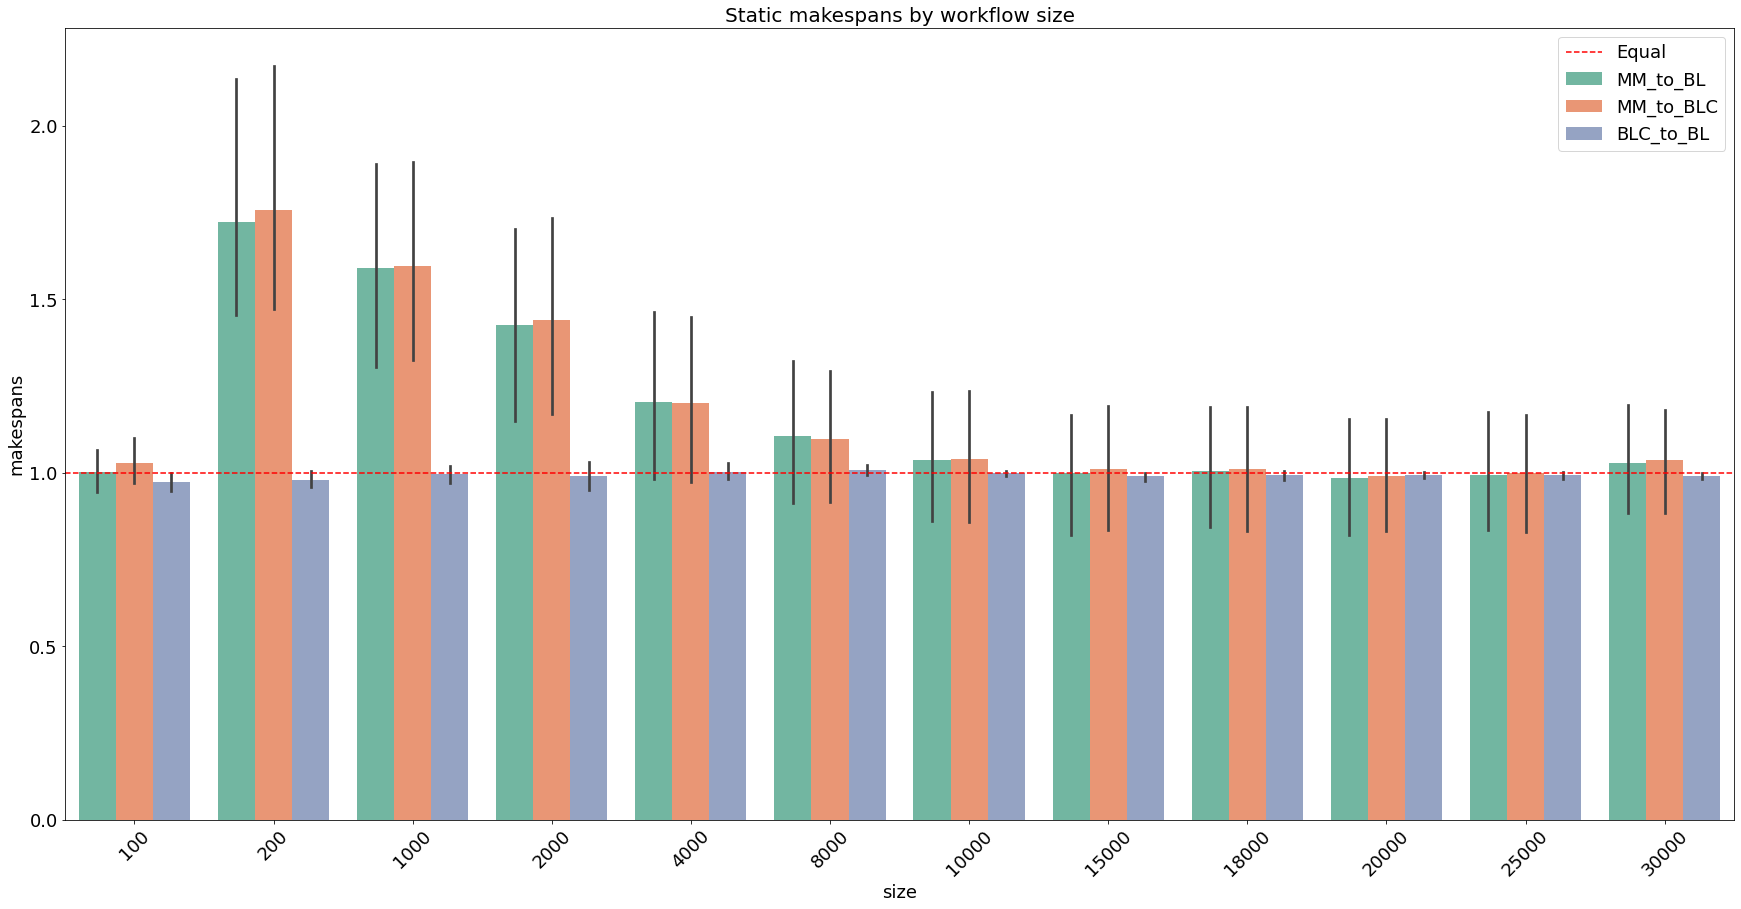

In [26]:
df_plot = merged_df_var1[['size', 'ms_2_A1', 'ms_2_A2', 'ms_2_A3']].copy()

df_plot['MM_to_BL'] = df_plot['ms_2_A3'] / df_plot['ms_2_A1']
df_plot['MM_to_BLC'] = df_plot['ms_2_A3'] / df_plot['ms_2_A2']
df_plot['BLC_to_BL'] = df_plot['ms_2_A2'] / df_plot['ms_2_A1']

# Step 2: Melt to long format
df_long = df_plot.melt(id_vars='size', 
                      # value_vars=['ms_2_A1', 'ms_2_A2', 'ms_2_A3'],
                       value_vars=['MM_to_BL','MM_to_BLC','BLC_to_BL'],
                       var_name='Algorithm', 
                       value_name='Makespan')

# Optional: Clean up algorithm names
df_long['Algorithm'] = df_long['Algorithm'].str.replace('ms_2_', '')

# Step 3: Plot
plt.figure(figsize=(24, 12))

ax = sns.barplot(data=df_long, x='size', y='Makespan', hue='Algorithm', estimator=gmean, palette="Set2")
baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')
plt.xticks(rotation=45)

plt.tight_layout()

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('size', fontsize=18)
plt.ylabel('makespans', fontsize=18)
plt.legend(fontsize=18)  
#ax.set_yscale("log") 
plt.title('Static makespans by workflow size', fontsize=20)
plt.show()


./param-study-pcsp/merged/*.txt
                 wf_name     inp_size       ms_1_A1       ms_2_A1  \
0      atacseq_30000.dot  14091675276  1.590399e+09  1.919821e+09   
1      chipseq_15000.dot  41366257414  4.665536e+09  4.792466e+09   
2    methylseq_15000.dot   6761426956  1.221361e+08  1.459471e+08   
3      atacseq_15000.dot   3908761308  2.921288e+08  2.357925e+08   
4                  eager  19075314980           NaN           NaN   
..                   ...          ...           ...           ...   
266                eager  19132169434           NaN           NaN   
267  methylseq_10000.dot  17027257018  3.137818e+08  4.278103e+08   
268        eager_200.dot   8330435694  5.612854e+06  3.178859e+06   
269  methylseq_18000.dot  22500260922  7.739336e+08  1.113855e+09   
270    chipseq_10000.dot   4807293396  3.076025e+08  2.437705e+08   

          ms_1_A2       ms_2_A2       ms_1_A3       ms_2_A3     ms_1_BASE  \
0    1.590399e+09  1.919821e+09  1.588983e+09  2.810840e+09  1

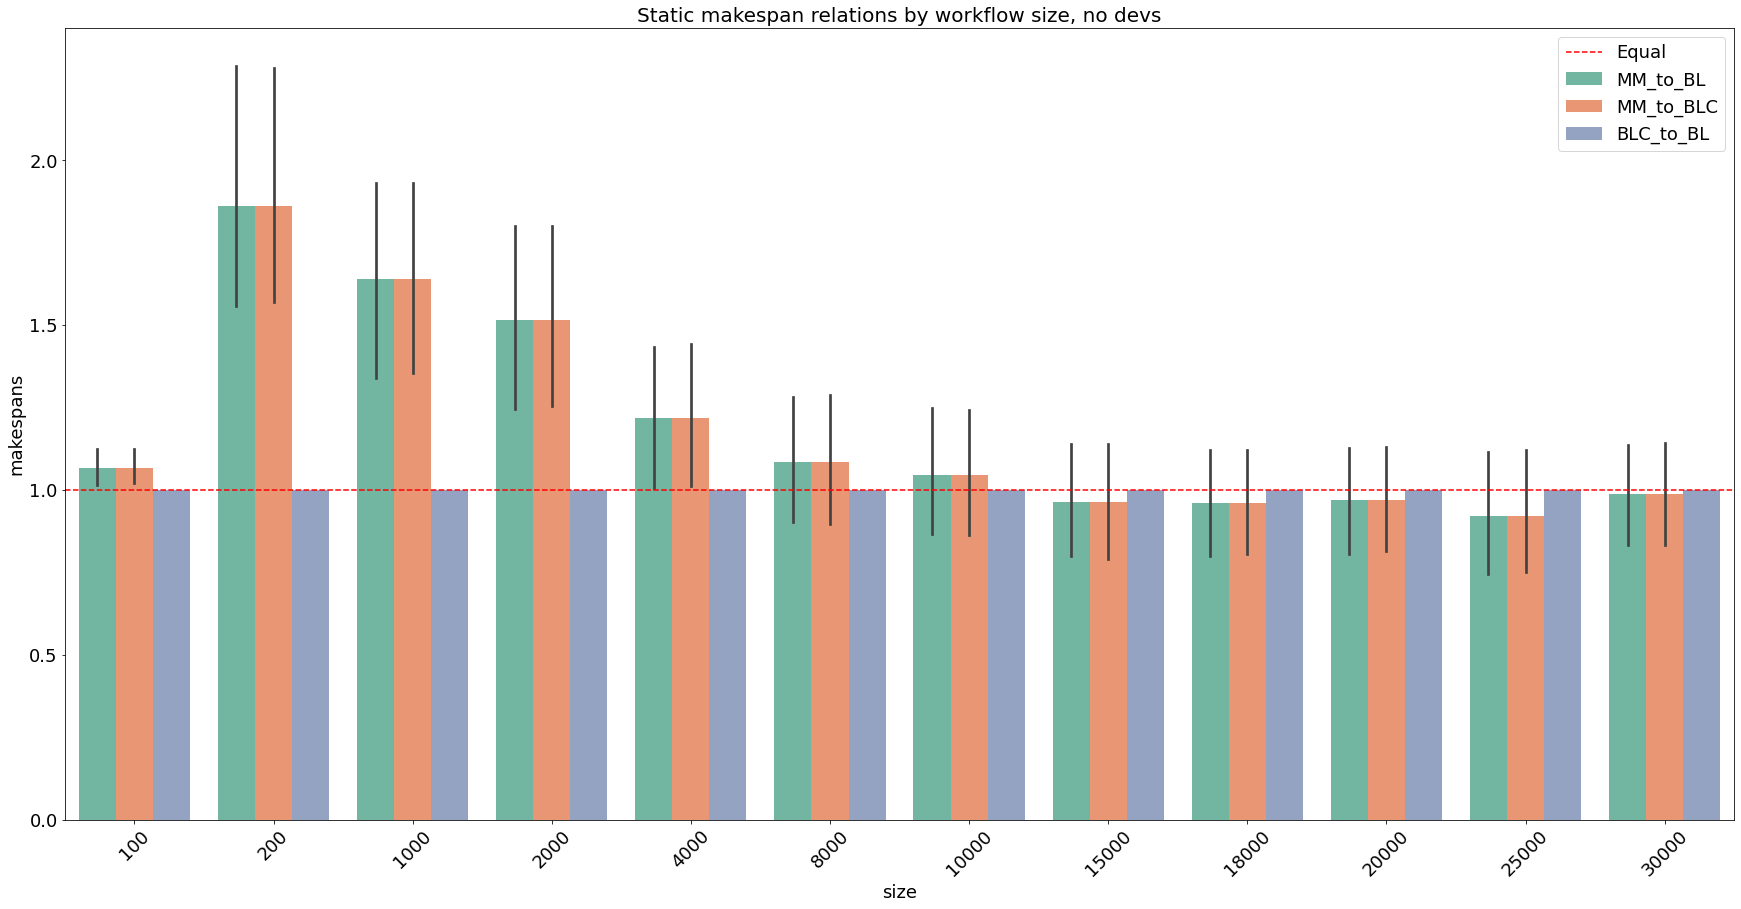

In [27]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!A2 IST A1!!!!!!!!!!!!!!!!!!!!!!!!!!!!
path = "./param-study-pcsp/merged/*.txt"
print(path)
from scipy.stats import gmean

patterndevs = r'^(BASE|A\d+)-ndev~(pspw\+\d)'

dfsrw=read_dfs(path,patterndevs, 2)
#print(dfsrw)
#dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar3 = [dfsrw[('A1','pspw+2')], dfsrw[('A1','pspw+2')], dfsrw[('A3','pspw+2')], dfsrw[('BASE','pspw+2')]]
merged_df_var3 = merge_correct_columns(dfsVar3, labels)
print(merged_df_var3)

df_plot = merged_df_var3[['size', 'ms_2_A1', 'ms_2_A2', 'ms_2_A3']].copy()

df_plot['MM_to_BL'] = df_plot['ms_2_A3'] / df_plot['ms_2_A1']
df_plot['MM_to_BLC'] = df_plot['ms_2_A3'] / df_plot['ms_2_A2']
df_plot['BLC_to_BL'] = df_plot['ms_2_A2'] / df_plot['ms_2_A1']

# Step 2: Melt to long format
df_long = df_plot.melt(id_vars='size', 
                      # value_vars=['ms_2_A1', 'ms_2_A2', 'ms_2_A3'],
                       value_vars=['MM_to_BL','MM_to_BLC','BLC_to_BL'],
                       var_name='Algorithm', 
                       value_name='Makespan')

# Optional: Clean up algorithm names
df_long['Algorithm'] = df_long['Algorithm'].str.replace('ms_2_', '')

# Step 3: Plot
plt.figure(figsize=(24, 12))

ax = sns.barplot(data=df_long, x='size', y='Makespan', hue='Algorithm', estimator=gmean, palette="Set2")
baseline_line = plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Equal')
plt.xticks(rotation=45)

plt.tight_layout()

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('size', fontsize=18)
plt.ylabel('makespans', fontsize=18)
plt.legend(fontsize=18)  
#ax.set_yscale("log") 
plt.title('Static makespan relations by workflow size, no devs', fontsize=20)
plt.show()


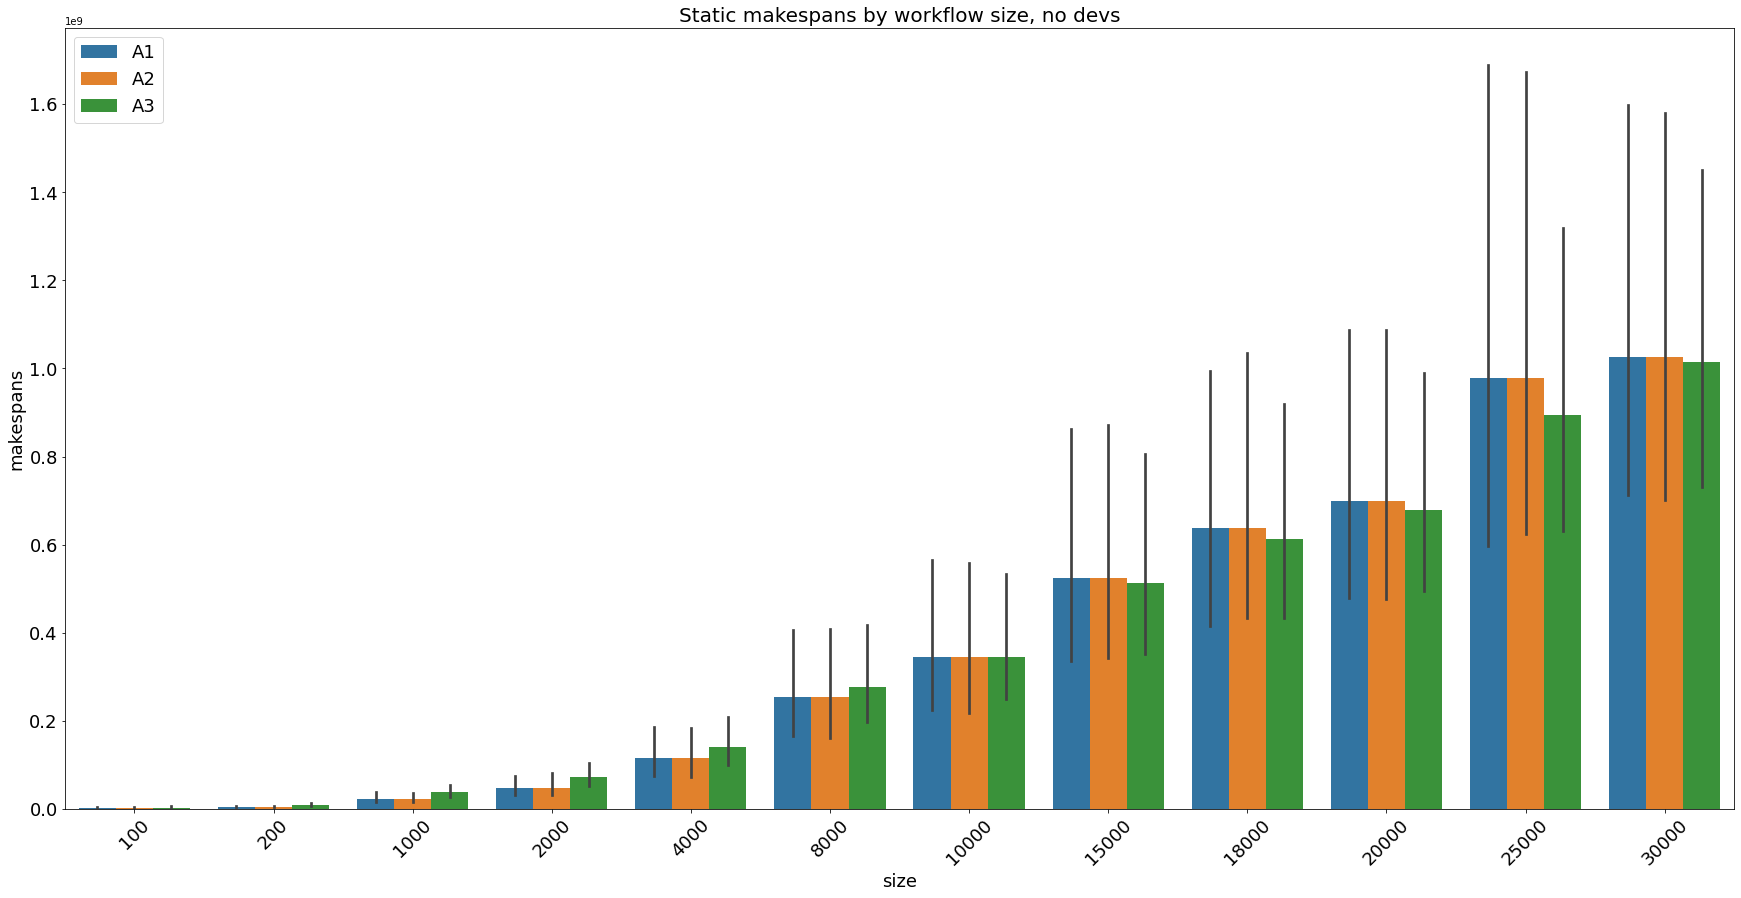

In [28]:
df_plot = merged_df_var3[['size', 'ms_2_A1', 'ms_2_A2', 'ms_2_A3']].copy()

# Step 2: Melt to long format
df_long = df_plot.melt(id_vars='size', 
                       value_vars=['ms_2_A1', 'ms_2_A2', 'ms_2_A3'],
                       var_name='Algorithm', 
                       value_name='Makespan')

# Optional: Clean up algorithm names
df_long['Algorithm'] = df_long['Algorithm'].str.replace('ms_2_', '')

# Step 3: Plot
plt.figure(figsize=(24, 12))

ax = sns.barplot(data=df_long, x='size', y='Makespan', hue='Algorithm', estimator=gmean)
#ax.set_yscale("log") 
plt.xticks(rotation=45)

plt.tight_layout()

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('size', fontsize=18)
plt.ylabel('makespans', fontsize=18)
plt.legend(fontsize=18)  
plt.title('Static makespans by workflow size, no devs', fontsize=20)
plt.show()


./param-study-pcsp/merged/*.txt
       size              wf_name     inp_size      relation         ratio  \
275   30000    atacseq_30000.dot  14091675276   dyn_vs_base  3.922012e+05   
276   15000    chipseq_15000.dot  41366257414   dyn_vs_base  1.202671e+05   
277   15000  methylseq_15000.dot   6761426956   dyn_vs_base  1.327718e+04   
278   15000    atacseq_15000.dot   3908761308   dyn_vs_base  1.065994e+06   
279     100                eager  19075314980   dyn_vs_base  1.007283e+00   
...     ...                  ...          ...           ...           ...   
2470    100                eager  19132169434  stat_vs_base  1.058825e+00   
2471  10000  methylseq_10000.dot  17027257018  stat_vs_base  1.383351e+04   
2472    200        eager_200.dot   8330435694  stat_vs_base  4.822697e-01   
2473  18000  methylseq_18000.dot  22500260922  stat_vs_base  6.260515e+04   
2474  10000    chipseq_10000.dot   4807293396  stat_vs_base  8.884129e+05   

     algorithm  
275   MeDiH-BL  
276   MeD

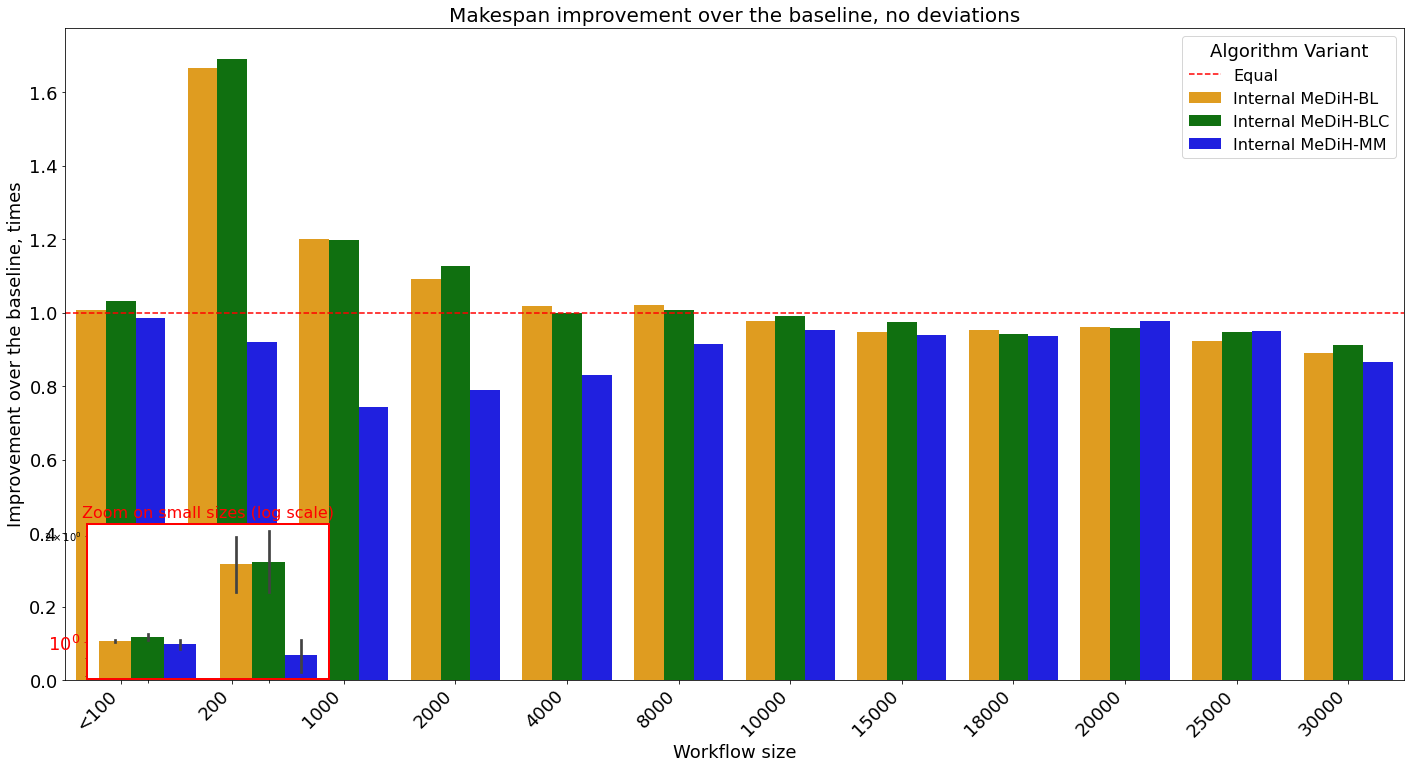

     size               alg_rel     ratio
0     100   MeDiH-BL - internal  1.007268
1     100  MeDiH-BLC - internal  1.032852
2     100   MeDiH-MM - internal  0.985519
3     200   MeDiH-BL - internal  1.665762
4     200  MeDiH-BLC - internal  1.691806
5     200   MeDiH-MM - internal  0.919244
6    1000   MeDiH-BL - internal  1.199476
7    1000  MeDiH-BLC - internal  1.199005
8    1000   MeDiH-MM - internal  0.743048
9    2000   MeDiH-BL - internal  1.091267
10   2000  MeDiH-BLC - internal  1.126395
11   2000   MeDiH-MM - internal  0.789248
12   4000   MeDiH-BL - internal  1.018413
13   4000  MeDiH-BLC - internal  0.999710
14   4000   MeDiH-MM - internal  0.831527
15   8000   MeDiH-BL - internal  1.020985
16   8000  MeDiH-BLC - internal  1.006229
17   8000   MeDiH-MM - internal  0.914965
18  10000   MeDiH-BL - internal  0.978451
19  10000  MeDiH-BLC - internal  0.992369
20  10000   MeDiH-MM - internal  0.953134
21  15000   MeDiH-BL - internal  0.948062
22  15000  MeDiH-BLC - internal  0

In [103]:
path = "./param-study-pcsp/merged/*.txt"
print(path)
from scipy.stats import gmean

patterndevs = r'^(BASE|A\d+)-ndev~(pspw\+\d)'

dfs=read_dfs(path,patterndevs, 2)
#print(dfs)


#dfsVar1 = [dfsrw[('A1','10dev')], dfsrw[('A1','30dev')], dfsrw[('A1','50dev')]]
labels = ['A1', 'A2', 'A3', 'BASE']
dfsVar3 = [dfsrw[('A1','pspw+2')], dfsrw[('A1','pspw+2')], dfsrw[('A3','pspw+2')], dfsrw[('BASE','pspw+2')]]
merged_df_var1 = merge_correct_columns(dfsVar1, labels)
#print(merged_df_var1)
plot_df = buld_plot_df(merged_df_var1)


plotvsbase = plot_df[(plot_df['relation']=="stat_vs_base") | (plot_df['relation']=="dyn_vs_base")]
plotvsbase.to_csv(f'plot_rels_vsbase_pcsp+2.csv')
print(plotvsbase)

plotDynAndStaticVsBase(plot_df, "no deviations")

In [5]:
 %history

import glob
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.testing.print_coercion_tables import print_new_cast_table
from scipy.stats import gmean
import scipy.stats as stats
import re
import os

from functools import reduce
from matplotlib.colors import to_rgb, to_hex
import colorsys

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
def safe_gmean(x):
    x = np.array(x)
    x = x[x > 0]  # only positive values
    return gmean(x) if len(x) > 0 else np.nan

# Helper to classify size
def size_category(size):
    if size < 8000:
        return "Small"
    elif size <= 15000:
        return "Middle"
    else:
        return "Large"
    
palette = {
    'MeDiH-MM - dyn_vs_base': 'blue',
    'MeDiH-MM - stat_vs_base': 'darkblue',
    'MeDiH-BL - dyn_vs_base': 'orange',
    'MeDiH-BL - stat_vs_base': 'darkorange',
    'MeDiH-BLC - dyn_vs_base': 'green',
    'MeDiH-BLC - stat_